In [1]:
try:
  import google.colab
  is_running_on_colab = True
  !pip install gdsfactory[cad] > /dev/null
  
except ImportError:
  is_running_on_colab = False

In [2]:
import gdsfactory as gf
gf.CONF.display_type = 'klayout'

# Layout tutorial

A `Component` is like an empty canvas, where you can add polygons, references to other Components and ports (to connect to other components)

![](https://i.imgur.com/oeuKGsc.png)

In gdsfactory **all dimensions** are in **microns**

2023-11-25 15:12:22.427 | WARNING  | gdsfactory.pdk:get_active_pdk:721 - No active PDK. Activating generic PDK.

2023-11-25 15:12:24.888 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'C:\\Users\\s3923133\\AppData\\Local\\miniconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-11-25 15:12:24.898 | INFO     | gdsfactory.pdk:activate:341 - 'generic' PDK is now active


You can install `pip install gdsfactory` for better visualization


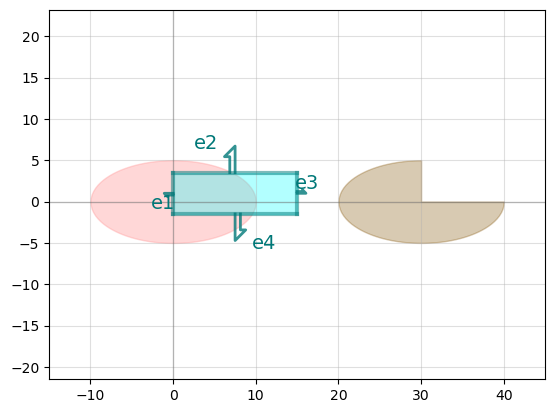

In [3]:
import gdsfactory as gf

e = gf.components.ellipse(radii=(10, 5), layer=(1, 0))
r = gf.components.rectangle(size=(15, 5), layer=(2, 0))
b = gf.geometry.boolean(e, r, operation="not", precision=1e-6, layer=(3, 0))
# Other operations include 'and', 'or', 'xor', or equivalently 'A-B', 'B-A', 'A+B'


# Plot the originals and the result
c = gf.Component("bool")
c.add_ref(e)
c.add_ref(r).movey(-1.5)
c.add_ref(b).movex(30)
c.plot()

## Polygons

You can add polygons to different layers.

2023-11-25 15:15:36.830 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'C:\\Users\\s3923133\\AppData\\Local\\miniconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-11-25 15:15:36.841 | INFO     | gdsfactory.pdk:activate:341 - 'generic' PDK is now active


You can install `pip install gdsfactory` for better visualization


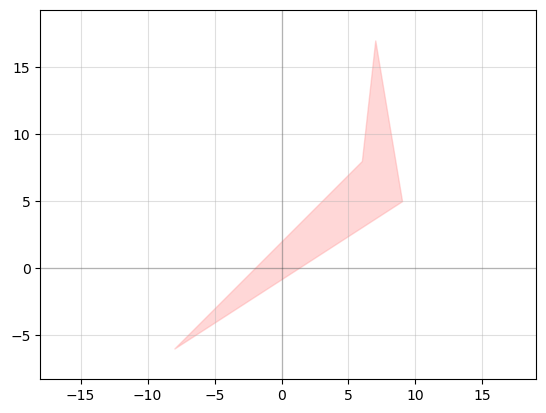

In [4]:
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()

PDK = get_generic_pdk()
PDK.activate()


@gf.cell
def demo_polygons():
    # Create a blank component (essentially an empty GDS cell with some special features)
    c = gf.Component()

    # Create and add a polygon from separate lists of x points and y points
    # (Can also be added like [(x1,y1), (x2,y2), (x3,y3), ... ]
    poly1 = c.add_polygon(
        [(-8, 6, 7, 9), (-6, 8, 17, 5)], layer=(1, 0)
    )  # GDS layers are tuples of ints (but if we use only one number it assumes the other number is 0)
    return c


c = demo_polygons()
c.plot()  # show it in KLayout

In [ ]:
c = gf.Component("enclosure1")
r = c << gf.components.ring_single()
c.plot()

## Connect **ports**

Components can have a "Port" that allows you to connect ComponentReferences together like legos.

You can write a simple function to make a rectangular straight, assign ports to the ends, and then connect those rectangles together.

Notice that `connect` transform each reference but things won't remain connected if you move any of the references afterwards.


In [ ]:
@gf.cell
def straight(length=10, width=1, layer=(1, 0)):
    WG = gf.Component()
    WG.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    WG.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    WG.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return WG


c = gf.Component("straights_not_connected")

wg1 = c << straight(length=10, width=2.5, layer=(1, 0))
wg2 = c << straight(length=11, width=2.5, layer=(2, 0))
wg3 = c << straight(length=15, width=2.5, layer=(3, 0))
wg2.movey(10).rotate(10)
wg3.movey(20).rotate(15)

c.plot()

Now we can connect everything together using the ports:

Each straight has two ports: 'o1' and 'o2', respectively on the East and West sides of the rectangular straight component. These are arbitrary
names defined in our straight() function above

In [ ]:
# Let's keep wg1 in place on the bottom, and connect the other straights to it.
# To do that, on wg2 we'll grab the "o1" port and connect it to the "o2" on wg1:
wg2.connect("o1", wg1.ports["o2"])
# Next, on wg3 let's grab the "o1" port and connect it to the "o2" on wg2:
wg3.connect("o1", wg2.ports["o2"])

c.plot()

Ports can be added by copying existing ports. In the example below, ports are added at the component-level on c from the existing ports of children wg1 and wg3
(i.e. eastmost and westmost ports)

In [ ]:
c.add_port("o1", port=wg1.ports["o1"])
c.add_port("o2", port=wg3.ports["o2"])
c.plot()

## Write

You can write your Component to:

- GDS file (Graphical Database System) or OASIS for chips.
- gerber for PCB.
- STL for 3d printing.

In [ ]:
import gdsfactory as gf

c = gf.components.cross()
c.write_gds("demo.gds")
c.plot()

You can see the GDS file in Klayout viewer.

Sometimes you also want to save the GDS together with metadata (settings, port names, widths, locations ...) in YAML

In [ ]:
c.write_gds("demo.gds", with_metadata=True)

You can also write it in OASIS format

In [ ]:
c.write_oas("demo.oas")

Or in STL for 3D printing or for integrating with other 3D CAD or simulation tools.

In [ ]:
c.write_stl("demo.stl")

In [ ]:
scene = c.to_3d()
scene.show()

## Importing GDS files

`gf.import_gds()` allows you to easily import external GDSII files.  It imports a single cell from the external GDS file and converts it into a gdsfactory component.

2023-11-21 13:59:03.491 | INFO     | gdsfactory.component:_write_library:1914 - Wrote to 'myoutput.gds'


You can install `pip install gdsfactory` for better visualization


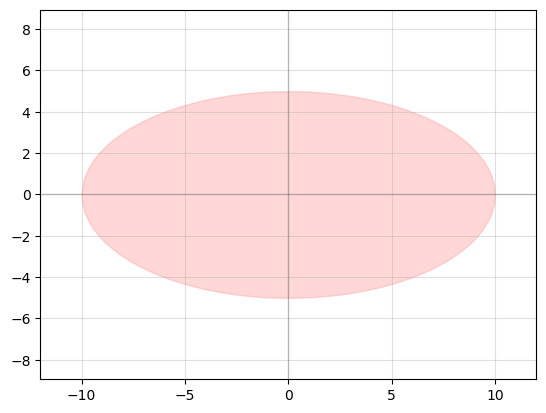

In [6]:
D = gf.components.ellipse()
D.write_gds("myoutput.gds")
D2 = gf.import_gds(gdspath="myoutput.gds", cellname=None, flatten=False)
D2.plot()

# Generic_tech

gdsfactory includes a generic Technology module in `gdsfactory.generic_tech` that you can use as an inspiration to create your own.

## LayerMap

A layer map maps layer names to a integer numbers pair  (GDSlayer, GDSpurpose)

Each foundry uses different GDS layer numbers for different process steps.

We follow the generic layer numbers from the book "Silicon Photonics Design: From Devices to Systems Lukas Chrostowski, Michael Hochberg".

| GDS (layer, purpose) | layer_name | Description                                                 |
| -------------------- | ---------- | ----------------------------------------------------------- |
| 1 , 0                | WG         | 220 nm Silicon core                                         |
| 2 , 0                | SLAB150    | 150nm Silicon slab (70nm shallow Etch for grating couplers) |
| 3 , 0                | SLAB90     | 90nm Silicon slab (for modulators)                          |
| 4, 0                 | DEEPTRENCH | Deep trench                                                 |
| 47, 0                | MH         | heater                                                      |
| 41, 0                | M1         | metal 1                                                     |
| 45, 0                | M2         | metal 2                                                     |
| 40, 0                | VIAC       | VIAC to contact Ge, NPP or PPP                              |
| 44, 0                | VIA1       | VIA1                                                        |
| 46, 0                | PADOPEN    | Bond pad opening                                            |
| 51, 0                | UNDERCUT   | Undercut                                                    |
| 66, 0                | TEXT       | Text markup                                                 |
| 64, 0                | FLOORPLAN  | Mask floorplan                                              |


In [7]:

from pydantic import BaseModel

import gdsfactory as gf
from gdsfactory.generic_tech import LAYER, LAYER_STACK
from gdsfactory.generic_tech.get_klayout_pyxs import get_klayout_pyxs
from gdsfactory.technology import LayerLevel, LayerStack, LayerViews
from gdsfactory.generic_tech import get_generic_pdk

In [8]:
Layer = tuple[int, int]

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()


class GenericLayerMap(BaseModel):
    """Generic layermap based on book.

    Lukas Chrostowski, Michael Hochberg, "Silicon Photonics Design",
    Cambridge University Press 2015, page 353
    You will need to create a new LayerMap with your specific foundry layers.
    """

    WAFER: Layer = (99999, 0)

    WG: Layer = (1, 0)
    WGCLAD: Layer = (111, 0)
    SLAB150: Layer = (2, 0)
    SLAB90: Layer = (3, 0)
    DEEPTRENCH: Layer = (4, 0)
    GE: Layer = (5, 0)
    UNDERCUT: Layer = (6, 0)
    WGN: Layer = (34, 0)
    WGN_CLAD: Layer = (36, 0)

    N: Layer = (20, 0)
    NP: Layer = (22, 0)
    NPP: Layer = (24, 0)
    P: Layer = (21, 0)
    PP: Layer = (23, 0)
    PPP: Layer = (25, 0)
    GEN: Layer = (26, 0)
    GEP: Layer = (27, 0)

    HEATER: Layer = (47, 0)
    M1: Layer = (41, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    VIAC: Layer = (40, 0)
    VIA1: Layer = (44, 0)
    VIA2: Layer = (43, 0)
    PADOPEN: Layer = (46, 0)

    DICING: Layer = (100, 0)
    NO_TILE_SI: Layer = (71, 0)
    PADDING: Layer = (67, 0)
    DEVREC: Layer = (68, 0)
    FLOORPLAN: Layer = (64, 0)
    TEXT: Layer = (66, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    PORTH: Layer = (70, 0)
    SHOW_PORTS: Layer = (1, 12)
    LABEL: Layer = (201, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    DRC_MARKER: Layer = (205, 0)
    LABEL_INSTANCE: Layer = (206, 0)
    ERROR_MARKER: Layer = (207, 0)
    ERROR_PATH: Layer = (208, 0)

    SOURCE: Layer = (110, 0)
    MONITOR: Layer = (101, 0)

    class Config:
        """pydantic config."""

        frozen = True
        extra = "forbid"


LAYER = GenericLayerMap()
LAYER

2023-11-21 13:59:09.434 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'C:\\Users\\s3923133\\AppData\\Local\\miniconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-11-21 13:59:09.445 | INFO     | gdsfactory.pdk:activate:341 - 'generic' PDK is now active



GenericLayerMap(
    WAFER=(99999, 0),
    WG=(1, 0),
    WGCLAD=(111, 0),
    SLAB150=(2, 0),
    SLAB90=(3, 0),
    DEEPTRENCH=(4, 0),
    GE=(5, 0),
    UNDERCUT=(6, 0),
    WGN=(34, 0),
    WGN_CLAD=(36, 0),
    N=(20, 0),
    NP=(22, 0),
    NPP=(24, 0),
    P=(21, 0),
    PP=(23, 0),
    PPP=(25, 0),
    GEN=(26, 0),
    GEP=(27, 0),
    HEATER=(47, 0),
    M1=(41, 0),
    M2=(45, 0),
    M3=(49, 0),
    VIAC=(40, 0),
    VIA1=(44, 0),
    VIA2=(43, 0),
    PADOPEN=(46, 0),
    DICING=(100, 0),
    NO_TILE_SI=(71, 0),
    PADDING=(67, 0),
    DEVREC=(68, 0),
    FLOORPLAN=(64, 0),
    TEXT=(66, 0),
    PORT=(1, 10),
    PORTE=(1, 11),
    PORTH=(70, 0),
    SHOW_PORTS=(1, 12),
    LABEL=(201, 0),
    LABEL_SETTINGS=(202, 0),
    TE=(203, 0),
    TM=(204, 0),
    DRC_MARKER=(205, 0),
    LABEL_INSTANCE=(206, 0),
    ERROR_MARKER=(207, 0),
    ERROR_PATH=(208, 0),
    SOURCE=(110, 0),
    MONITOR=(101, 0)
)

### Extract layers

You can also extract layers using the `extract` function. This function returns a new flattened Component that contains the extracted layers.
A flat Component does not have references, and all the polygons are absorbed into the top cell.

2023-11-21 13:59:13.818 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'C:\\Users\\s3923133\\AppData\\Local\\miniconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-11-21 13:59:13.826 | INFO     | gdsfactory.pdk:activate:341 - 'generic' PDK is now active


You can install `pip install gdsfactory` for better visualization


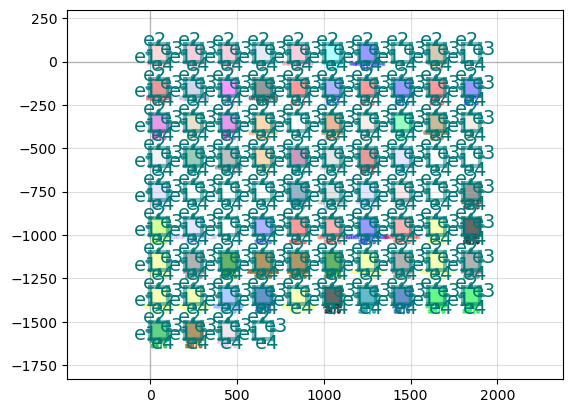

In [9]:
from gdsfactory.generic_tech import get_generic_pdk

PDK = get_generic_pdk()
PDK.activate()

LAYER_VIEWS = PDK.layer_views
c = LAYER_VIEWS.preview_layerset()
c.plot()

## LayerStack

Each layer also includes the information of thickness and position of each layer after fabrication.

This LayerStack can be used for creating a 3D model with `Component.to_3d` or running Simulations.

A GDS has different layers to describe the different fabrication process steps. And each grown layer needs thickness information and z-position in the stack.

![layer stack](https://i.imgur.com/GUb1Kav.png)

Lets define the layer stack for the generic layers in the generic_technology.

In [10]:
from gdsfactory.generic_tech.layer_map import LAYER
from gdsfactory.technology import LayerLevel, LayerStack

nm = 1e-3


class LayerStackParameters:
    """values used by get_layer_stack and get_process."""

    thickness_wg: float = 220 * nm
    thickness_slab_deep_etch: float = 90 * nm
    thickness_slab_shallow_etch: float = 150 * nm
    sidewall_angle_wg: float = 10
    thickness_clad: float = 3.0
    thickness_nitride: float = 350 * nm
    thickness_ge: float = 500 * nm
    gap_silicon_to_nitride: float = 100 * nm
    zmin_heater: float = 1.1
    zmin_metal1: float = 1.1
    thickness_metal1: float = 700 * nm
    zmin_metal2: float = 2.3
    thickness_metal2: float = 700 * nm
    zmin_metal3: float = 3.2
    thickness_metal3: float = 2000 * nm
    substrate_thickness: float = 10.0
    box_thickness: float = 3.0
    undercut_thickness: float = 5.0



def get_layer_stack(
    thickness_wg=LayerStackParameters.thickness_wg,
    thickness_slab_deep_etch=LayerStackParameters.thickness_slab_deep_etch,
    thickness_slab_shallow_etch=LayerStackParameters.thickness_slab_shallow_etch,
    sidewall_angle_wg=LayerStackParameters.sidewall_angle_wg,
    thickness_clad=LayerStackParameters.thickness_clad,
    thickness_nitride=LayerStackParameters.thickness_nitride,
    thickness_ge=LayerStackParameters.thickness_ge,
    gap_silicon_to_nitride=LayerStackParameters.gap_silicon_to_nitride,
    zmin_heater=LayerStackParameters.zmin_heater,
    zmin_metal1=LayerStackParameters.zmin_metal1,
    thickness_metal1=LayerStackParameters.thickness_metal1,
    zmin_metal2=LayerStackParameters.zmin_metal2,
    thickness_metal2=LayerStackParameters.thickness_metal2,
    zmin_metal3=LayerStackParameters.zmin_metal3,
    thickness_metal3=LayerStackParameters.thickness_metal3,
    substrate_thickness=LayerStackParameters.substrate_thickness,
    box_thickness=LayerStackParameters.box_thickness,
    undercut_thickness=LayerStackParameters.undercut_thickness,
) -> LayerStack:
    """Returns generic LayerStack.

    based on paper https://www.degruyter.com/document/doi/10.1515/nanoph-2013-0034/html

    Args:
        thickness_wg: waveguide thickness in um.
        thickness_slab_deep_etch: for deep etched slab.
        thickness_shallow_etch: thickness for the etch in um.
        sidewall_angle_wg: waveguide side angle.
        thickness_clad: cladding thickness in um.
        thickness_nitride: nitride thickness in um.
        thickness_ge: germanium thickness.
        gap_silicon_to_nitride: distance from silicon to nitride in um.
        zmin_heater: TiN heater.
        zmin_metal1: metal1.
        thickness_metal1: metal1 thickness.
        zmin_metal2: metal2.
        thickness_metal2: metal2 thickness.
        zmin_metal3: metal3.
        thickness_metal3: metal3 thickness.
        substrate_thickness: substrate thickness in um.
        box_thickness: bottom oxide thickness in um.
        undercut_thickness: thickness of the silicon undercut.
    """

    thickness_deep_etch = thickness_wg - thickness_slab_deep_etch
    thickness_shallow_etch = thickness_wg - thickness_slab_shallow_etch

    return LayerStack(
        layers=dict(
            substrate=LayerLevel(
                layer=LAYER.WAFER,
                thickness=substrate_thickness,
                zmin=-substrate_thickness - box_thickness,
                material="si",
                mesh_order=101,
                background_doping_concentration=1e14,
                background_doping_ion="Boron",
                orientation="100",
            ),
            box=LayerLevel(
                layer=LAYER.WAFER,
                thickness=box_thickness,
                zmin=-box_thickness,
                material="sio2",
                mesh_order=9,
            ),
            core=LayerLevel(
                layer=LAYER.WG,
                thickness=thickness_wg,
                zmin=0.0,
                material="si",
                mesh_order=2,
                sidewall_angle=sidewall_angle_wg,
                width_to_z=0.5,
                background_doping_concentration=1e14,
                background_doping_ion="Boron",
                orientation="100",
                info={"active": True},
            ),
            shallow_etch=LayerLevel(
                layer=LAYER.SHALLOW_ETCH,
                thickness=thickness_shallow_etch,
                zmin=0.0,
                material="si",
                mesh_order=1,
                layer_type="etch",
                into=["core"],
                derived_layer=LAYER.SLAB150,
            ),
            deep_etch=LayerLevel(
                layer=LAYER.DEEP_ETCH,
                thickness=thickness_deep_etch,
                zmin=0.0,
                material="si",
                mesh_order=1,
                layer_type="etch",
                into=["core"],
                derived_layer=LAYER.SLAB90,
            ),
            clad=LayerLevel(
                layer=LAYER.WAFER,
                zmin=0.0,
                material="sio2",
                thickness=thickness_clad,
                mesh_order=10,
            ),
            slab150=LayerLevel(
                layer=LAYER.SLAB150,
                thickness=150e-3,
                zmin=0,
                material="si",
                mesh_order=3,
            ),
            slab90=LayerLevel(
                layer=LAYER.SLAB90,
                thickness=thickness_slab_deep_etch,
                zmin=0.0,
                material="si",
                mesh_order=2,
            ),
            nitride=LayerLevel(
                layer=LAYER.WGN,
                thickness=thickness_nitride,
                zmin=thickness_wg + gap_silicon_to_nitride,
                material="sin",
                mesh_order=2,
            ),
            ge=LayerLevel(
                layer=LAYER.GE,
                thickness=thickness_ge,
                zmin=thickness_wg,
                material="ge",
                mesh_order=1,
            ),
            undercut=LayerLevel(
                layer=LAYER.UNDERCUT,
                thickness=-undercut_thickness,
                zmin=-box_thickness,
                material="air",
                z_to_bias=(
                    [0, 0.3, 0.6, 0.8, 0.9, 1],
                    [-0, -0.5, -1, -1.5, -2, -2.5],
                ),
                mesh_order=1,
            ),
            via_contact=LayerLevel(
                layer=LAYER.VIAC,
                thickness=zmin_metal1 - thickness_slab_deep_etch,
                zmin=thickness_slab_deep_etch,
                material="Aluminum",
                mesh_order=1,
                sidewall_angle=-10,
                width_to_z=0,
            ),
            metal1=LayerLevel(
                layer=LAYER.M1,
                thickness=thickness_metal1,
                zmin=zmin_metal1,
                material="Aluminum",
                mesh_order=2,
            ),
            heater=LayerLevel(
                layer=LAYER.HEATER,
                thickness=750e-3,
                zmin=zmin_heater,
                material="TiN",
                mesh_order=2,
            ),
            via1=LayerLevel(
                layer=LAYER.VIA1,
                thickness=zmin_metal2 - (zmin_metal1 + thickness_metal1),
                zmin=zmin_metal1 + thickness_metal1,
                material="Aluminum",
                mesh_order=1,
            ),
            metal2=LayerLevel(
                layer=LAYER.M2,
                thickness=thickness_metal2,
                zmin=zmin_metal2,
                material="Aluminum",
                mesh_order=2,
            ),
            via2=LayerLevel(
                layer=LAYER.VIA2,
                thickness=zmin_metal3 - (zmin_metal2 + thickness_metal2),
                zmin=zmin_metal2 + thickness_metal2,
                material="Aluminum",
                mesh_order=1,
            ),
            metal3=LayerLevel(
                layer=LAYER.M3,
                thickness=thickness_metal3,
                zmin=zmin_metal3,
                material="Aluminum",
                mesh_order=2,
            ),
        )
    )



LAYER_STACK = get_layer_stack()
layer_stack220 = LAYER_STACK

You can install `pip install gdsfactory` for better visualization


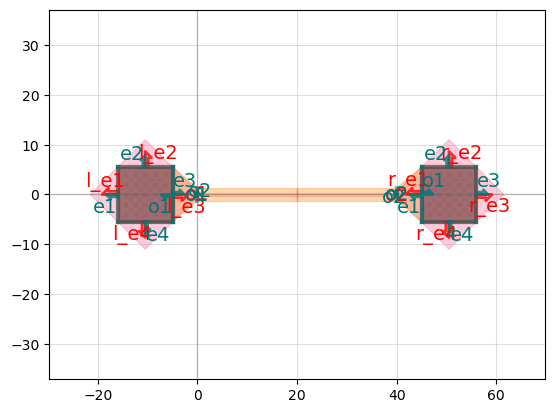

In [11]:
import gdsfactory as gf

c = gf.components.straight_heater_metal(length=40)
c.plot()

In [12]:
scene = c.to_3d(layer_stack=layer_stack220)
scene.show()

you need to `pip install trimesh`


ModuleNotFoundError: No module named 'trimesh'

You can install `pip install gdsfactory` for better visualization


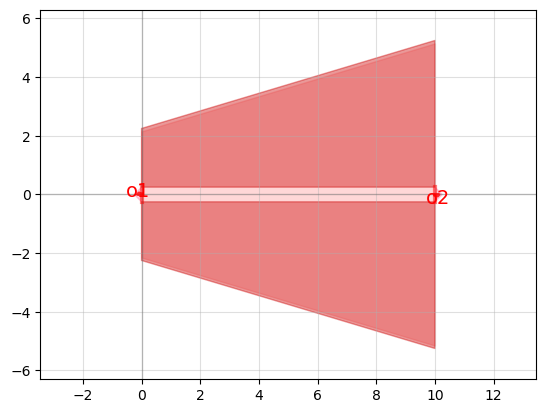

In [13]:
import gdsfactory as gf

c = gf.components.taper_strip_to_ridge_trenches()
c.plot()

In [14]:
scene = c.to_3d(layer_stack=layer_stack220)
scene.show()

you need to `pip install trimesh`


ModuleNotFoundError: No module named 'trimesh'

In [ ]:
# lets assume we have 900nm silicon instead of 220nm, You will see a much thicker waveguide under the metal heater.
layer_stack900 = get_layer_stack(thickness_wg=900 * nm)
scene = c.to_3d(layer_stack=layer_stack900)
scene.show()

In [ ]:
import gdsfactory as gf

c = gf.components.grating_coupler_elliptical_trenches()
c.plot()

In [ ]:
scene = c.to_3d()
scene.show()

## 3D rendering

To render components in 3D you will need to define two things:

1. LayerStack: for each layer contains thickness of each material and z position
2. LayerViews: for each layer contains view (color, pattern, opacity). You can load it with `gf.technology.LayerView.load_lyp()`

In [ ]:
heater = gf.components.straight_heater_metal(length=50)
heater.plot()

In [ ]:
scene = heater.to_3d()
scene.show()

As the sequence is defined as a string you can use the string operations to easily build complex sequences

# References and ports

gdsfactory defines your component once in memory and can add multiple References (Instances) to the same component.

As you build components you can include references to other components. Adding a reference is like having a pointer to a component.

The GDSII specification allows the use of references, and similarly gdsfactory uses them (with the `add_ref()` function).
what is a reference? Simply put:  **A reference does not contain any geometry. It only *points* to an existing geometry**.

Say you have a ridiculously large polygon with 100 billion vertices that you call BigPolygon. It's huge, and you need to use it in your design 250 times.
Well, a single copy of BigPolygon takes up 1MB of memory, so you don't want to make 250 copies of it
You can instead *references* the polygon 250 times.
Each reference only uses a few bytes of memory -- it only needs to know the memory address of BigPolygon, position, rotation and mirror.
This way, you can keep one copy of BigPolygon and use it again and again.

You can start by making a blank `Component` and add a single polygon to it.

In [ ]:
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

# Create a blank Component
p = gf.Component("component_with_polygon")

# Add a polygon
xpts = [0, 0, 5, 6, 9, 12]
ypts = [0, 1, 1, 2, 2, 0]
p.add_polygon([xpts, ypts], layer=(2, 0))

# plot the Component with the polygon in it
p.plot()

Now, you want to reuse this polygon repeatedly without creating multiple copies of it.

To do so, you need to make a second blank `Component`, this time called `c`.

In this new Component you *reference* our Component `p` which contains our polygon.

In [ ]:
c = gf.Component("Component_with_references")  # Create a new blank Component
poly_ref = c.add_ref(p)  # Reference the Component "p" that has the polygon in it
c.plot()

you just made a copy of your polygon -- but remember, you didn't actually
make a second polygon, you just made a reference (aka pointer) to the original
polygon.  Let's add two more references to `c`:

In [ ]:
poly_ref2 = c.add_ref(p)  # Reference the Component "p" that has the polygon in it
poly_ref3 = c.add_ref(p)  # Reference the Component "p" that has the polygon in it
c.plot()

Now you have 3x polygons all on top of each other.  Again, this would appear
useless, except that you can manipulate each reference independently. Notice that
when you called `c.add_ref(p)` above, we saved the result to a new variable each
time (`poly_ref`, `poly_ref2`, and `poly_ref3`)?  You can use those variables to
reposition the references.

In [ ]:
poly_ref2.rotate(90)  # Rotate the 2nd reference we made 90 degrees
poly_ref3.rotate(180)  # Rotate the 3rd reference we made 180 degrees
c.plot()

Now you're getting somewhere! You've only had to make the polygon once, but you're
able to reuse it as many times as you want.

## Modifying the referenced geometry

What happens when you change the original geometry that the reference points to?  In your case, your references in
`c` all point to the Component `p` that with the original polygon.  Let's try
adding a second polygon to `p`.

First you add the second polygon and make sure `P` looks like you expect:

In [ ]:
# Add a 2nd polygon to "p"
xpts = [14, 14, 16, 16]
ypts = [0, 2, 2, 0]
p.add_polygon([xpts, ypts], layer=(1, 0))
p.plot()

That looks good.  Now let's find out what happened to `c` that contains the
three references.  Keep in mind that you have not modified `c` or executed any
functions/operations on `c` -- all you have done is modify `p`.

In [ ]:
c.plot()

 **When you modify the original geometry, all of the
references automatically reflect the modifications.**  This is very powerful,
because you can use this to make very complicated designs from relatively simple
elements in a computation- and memory-efficient way.

Let's try making references a level deeper by referencing `c`.  Note here we use
the `<<` operator to add the references -- this is just shorthand, and is
exactly equivalent to using `add_ref()`

In [ ]:
c2 = gf.Component("array_sample")  # Create a new blank Component
d_ref1 = c2.add_ref(c)  # Reference the Component "c" that 3 references in it
d_ref2 = c2 << c  # Use the "<<" operator to create a 2nd reference to c.plot()
d_ref3 = c2 << c  # Use the "<<" operator to create a 3rd reference to c.plot()

d_ref1.move([20, 0])
d_ref2.move([40, 0])

c2.plot()

As you've seen you have two ways to add a reference to our component:

1. create the reference and add it to the component

In [ ]:
c = gf.Component("reference_sample")
w = gf.components.straight(width=0.6)
wr = w.ref()
c.add(wr)
c.plot()

2. or do it in a single line

In [ ]:
c = gf.Component("reference_sample_shorter_syntax")
wr = c << gf.components.straight(width=0.6)
c.plot()

in both cases you can move the reference `wr` after created

In [ ]:
c = gf.Component("two_references")
wr1 = c << gf.components.straight(width=0.6)
wr2 = c << gf.components.straight(width=0.6)
wr2.movey(10)
c.add_ports(wr1.get_ports_list(), prefix="bot_")
c.add_ports(wr2.get_ports_list(), prefix="top_")

In [ ]:
c.ports

You can also auto_rename ports using gdsfactory default convention, where ports are numbered clockwise starting from the bottom left

In [ ]:
c.auto_rename_ports()

In [ ]:
c.ports

In [ ]:
c.plot()

## Arrays of references

In GDS, there's a type of structure called a "ComponentReference" which takes a cell and repeats it NxM times on a fixed grid spacing. For convenience, `Component` includes this functionality with the add_array() function.
Note that CellArrays are not compatible with ports (since there is no way to access/modify individual elements in a GDS cellarray)

gdsfactory also provides with more flexible arrangement options if desired, see for example `grid()` and `packer()`.

As well as `gf.components.array`

Let's make a new Component and put a big array of our Component `c` in it:

In [ ]:
c3 = gf.Component("array_of_references")  # Create a new blank Component
aref = c3.add_array(
    c, columns=6, rows=3, spacing=[20, 15]
)  # Reference the Component "c" 3 references in it with a 3 rows, 6 columns array
c3.plot()

CellArrays don't have ports and there is no way to access/modify individual elements in a GDS cellarray.

gdsfactory provides you with similar functions in `gf.components.array` and `gf.components.array_2d`

In [ ]:
c4 = gf.Component("demo_array")  # Create a new blank Component
aref = c4 << gf.components.array(component=c, columns=3, rows=2)
c4.add_ports(aref.get_ports_list())
c4.plot()

In [ ]:
help(gf.components.array)

You can also create an array of references for periodic structures. Let's create a [Distributed Bragg Reflector](https://picwriter.readthedocs.io/en/latest/components/dbr.html)


In [ ]:
@gf.cell
def dbr_period(w1=0.5, w2=0.6, l1=0.2, l2=0.4, straight=gf.components.straight):
    """Return one DBR period."""
    c = gf.Component()
    r1 = c << straight(length=l1, width=w1)
    r2 = c << straight(length=l2, width=w2)
    r2.connect(port="o1", destination=r1.ports["o2"])
    c.add_port("o1", port=r1.ports["o1"])
    c.add_port("o2", port=r2.ports["o2"])
    return c


l1 = 0.2
l2 = 0.4
n = 3
period = dbr_period(l1=l1, l2=l2)
period.plot()

In [ ]:
dbr = gf.Component("DBR")
dbr.add_array(period, columns=n, rows=1, spacing=(l1 + l2, 100))
dbr.plot()

Finally we need to add ports to the new component

In [ ]:
p0 = dbr.add_port("o1", port=period.ports["o1"])
p1 = dbr.add_port("o2", port=period.ports["o2"])

p1.center = [(l1 + l2) * n, 0]
dbr.plot()

## Connect references

We have seen that once you create a reference you can manipulate the reference to move it to a location. Here we are going to connect that reference to a port. Remember that we follow that a certain reference `source` connects to a `destination` port

In [ ]:
bend = gf.components.bend_circular()
bend.plot()

In [ ]:
c = gf.Component("sample_reference_connect")

mmi = c << gf.components.mmi1x2()
b = c << gf.components.bend_circular()
b.connect("o1", destination=mmi.ports["o2"])

c.add_port("o1", port=mmi.ports["o1"])
c.add_port("o2", port=b.ports["o2"])
c.add_port("o3", port=mmi.ports["o3"])
c.plot()

You can also access the ports directly from the references

In [ ]:
c = gf.Component("sample_reference_connect_simpler")

mmi = c << gf.components.mmi1x2()
b = c << gf.components.bend_circular()
b.connect("o1", destination=mmi["o2"])

c.add_port("o1", port=mmi["o1"])
c.add_port("o2", port=b["o2"])
c.add_port("o3", port=mmi["o3"])
c.plot()

Notice that `connect` mates two ports together and does not imply that ports will remain connected.


## Port

You can name the ports as you want and use `gf.port.auto_rename_ports(prefix='o')` to rename them later on.

Here is the default naming convention.

Ports are numbered clock-wise starting from the bottom left corner.

Optical ports have `o` prefix and Electrical ports `e` prefix.

The port naming comes in most cases from the `gdsfactory.cross_section`. For example:

- `gdsfactory.cross_section.strip`  has ports `o1` for input and `o2` for output.
- `gdsfactory.cross_section.metal1` has ports `e1` for input and `e2` for output.

In [ ]:
size = 4
c = gf.components.nxn(west=2, south=2, north=2, east=2, xsize=size, ysize=size)
c.plot()

In [ ]:
c = gf.components.straight_heater_metal(length=30)
c.plot()

In [ ]:
c.ports

You can get the optical ports by `layer`

In [ ]:
c.get_ports_dict(layer=(1, 0))

or by `width`

In [ ]:
c.get_ports_dict(width=0.5)

In [ ]:
c0 = gf.components.straight_heater_metal()
c0.ports

In [ ]:
c1 = c0.copy()
c1.auto_rename_ports_layer_orientation()
c1.ports

In [ ]:
c2 = c0.copy()
c2.auto_rename_ports()
c2.ports

You can also rename them with a different port naming convention

- prefix: add `e` for electrical `o` for optical
- clockwise
- counter-clockwise
- orientation `E` East, `W` West, `N` North, `S` South


Here is the default one we use (clockwise starting from bottom left west facing port)

```
             3   4
             |___|_
         2 -|      |- 5
            |      |
         1 -|______|- 6
             |   |
             8   7

```

In [ ]:
c = gf.Component("demo_ports")
nxn = gf.components.nxn(west=2, north=2, east=2, south=2, xsize=4, ysize=4)
ref = c.add_ref(nxn)
c.add_ports(ref.ports)
c.plot()

In [ ]:
ref.get_ports_list()  # by default returns ports clockwise starting from bottom left west facing port

In [ ]:
c.auto_rename_ports()
c.plot()

Lets extend the East facing ports (orientation = 0 deg)

In [ ]:
cross_section = gf.cross_section.strip()

nxn = gf.components.nxn(
    west=2, north=2, east=2, south=2, xsize=4, ysize=4, cross_section=cross_section
)
c = gf.components.extension.extend_ports(component=nxn, orientation=0)
c.plot()

In [ ]:
c.pprint_ports()

In [ ]:
df = c.get_ports_pandas()
df

In [ ]:
df[df.port_type == "optical"]

## Port markers (Pins)

You can add pins (port markers) to each port. Different foundries do this differently, so gdsfactory supports all of them.

- square with port inside the component.
- square centered (half inside, half outside component).
- triangular pointing towards the outside of the port.
- path (SiEPIC).


by default Component.show() will add triangular pins, so you can see the direction of the port in Klayout.

In [ ]:
c = gf.components.mmi1x2(decorator=gf.add_pins.add_pins)
c.plot()

In [ ]:
c = gf.components.mmi1x2(decorator=gf.add_pins.add_pins_triangle)
c.plot()

## Component_sequence

When you have repetitive connections you can describe the connectivity as an ASCII map

In [ ]:
bend180 = gf.components.bend_circular180()
wg_pin = gf.components.straight_pin(length=40)
wg = gf.components.straight()

# Define a map between symbols and (component, input port, output port)
symbol_to_component = {
    "D": (bend180, "o1", "o2"),
    "C": (bend180, "o2", "o1"),
    "P": (wg_pin, "o1", "o2"),
    "-": (wg, "o1", "o2"),
}

# Generate a sequence
# This is simply a chain of characters. Each of them represents a component
# with a given input and and a given output

sequence = "DC-P-P-P-P-CD"
component = gf.components.component_sequence(
    sequence=sequence, symbol_to_component=symbol_to_component
)
component.name = "component_sequence"
component.plot()

You can install the klayout klive plugin to be able to see live updates on your GDS files:

![KLayout package](https://i.imgur.com/IZWH6U0.png)

# Movement

You can move, rotate and mirror ComponentReference as well as `Port`, `Polygon`, `ComponentReference`, `Label`, and `Group`

In [ ]:
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()

PDK = get_generic_pdk()

PDK.activate()

# Start with a blank Component
c = gf.Component("demo_movement")

# Create some more Components with shapes
T = gf.components.text("hello", size=10, layer=(1, 0))
E = gf.components.ellipse(radii=(10, 5), layer=(2, 0))
R = gf.components.rectangle(size=(10, 3), layer=(3, 0))

# Add the shapes to D as references
text = c << T
ellipse = c << E
rect1 = c << R
rect2 = c << R

c.plot()

In [ ]:
c = gf.Component("move_one_ellipse")
e1 = c << gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e2 = c << gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e1.movex(10)
c.plot()

In [ ]:
c = gf.Component("move_one_ellipse_xmin")
e1 = c << gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e2 = c << gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e2.xmin = e1.xmax
c.plot()

Now you can practice move and rotate the objects.

In [ ]:
c = gf.Component("two_ellipses_on_top_of_each_other")
E = gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e1 = c << E
e2 = c << E
c.plot()

In [ ]:
c = gf.Component("ellipse_moved")
e = gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e1 = c << e
e2 = c << e
e2.move(origin=[5, 5], destination=[10, 10])  # Translate by dx = 5, dy = 5
c.plot()

In [ ]:
c = gf.Component("ellipse_moved_v2")
e = gf.components.ellipse(radii=(10, 5), layer=(2, 0))
e1 = c << e
e2 = c << e
e2.move([5, 5])  # Translate by dx = 5, dy = 5
c.plot()

In [ ]:
c = gf.Component("rectangles")
r = gf.components.rectangle(size=(10, 5), layer=(2, 0))
rect1 = c << r
rect2 = c << r

rect1.rotate(45)  # Rotate the first straight by 45 degrees around (0,0)
rect2.rotate(
    -30, center=[1, 1]
)  # Rotate the second straight by -30 degrees around (1,1)
c.plot()

In [ ]:
c = gf.Component("mirror_demo")
text = c << gf.components.text("hello")
text.mirror(p1=[1, 1], p2=[1, 3])  # Reflects across the line formed by p1 and p2
c.plot()

In [ ]:
c = gf.Component("hello")
text = c << gf.components.text("hello")
c.plot()

Each Component and ComponentReference object has several properties which can be
used
to learn information about the object (for instance where it's center coordinate
is).  Several of these properties can actually be used to move the geometry by
assigning them new values.

Available properties are:

- `xmin` / `xmax`: minimum and maximum x-values of all points within the object
- `ymin` / `ymax`: minimum and maximum y-values of all points within the object
- `x`: centerpoint between minimum and maximum x-values of all points within the
object
- `y`: centerpoint between minimum and maximum y-values of all points within the
object
- `bbox`: bounding box (see note below) in format ((xmin,ymin),(xmax,ymax))
- `center`: center of bounding box

In [ ]:
print("bounding box:")
print(
    text.bbox
)  # Will print the bounding box of text in terms of [(xmin, ymin), (xmax, ymax)]
print("xsize and ysize:")
print(text.xsize)  # Will print the width of text in the x dimension
print(text.ysize)  # Will print the height of text in the y dimension
print("center:")
print(text.center)  # Gives you the center coordinate of its bounding box
print("xmax")
print(text.xmax)  # Gives you the rightmost (+x) edge of the text bounding box

Let's use these properties to manipulate our shapes to arrange them a little
better

In [ ]:
c = gf.Component("canvas")
text = c << gf.components.text("hello")
E = gf.components.ellipse(radii=(10, 5), layer=(3, 0))
R = gf.components.rectangle(size=(10, 5), layer=(2, 0))
rect1 = c << R
rect2 = c << R
ellipse = c << E

c.plot()

In [ ]:
# First let's center the ellipse
ellipse.center = [
    0,
    0,
]  # Move the ellipse such that the bounding box center is at (0,0)

# Next, let's move the text to the left edge of the ellipse
text.y = (
    ellipse.y
)  # Move the text so that its y-center is equal to the y-center of the ellipse
text.xmax = ellipse.xmin  # Moves the ellipse so its xmax == the ellipse's xmin

# Align the right edge of the rectangles with the x=0 axis
rect1.xmax = 0
rect2.xmax = 0

# Move the rectangles above and below the ellipse
rect1.ymin = ellipse.ymax + 5
rect2.ymax = ellipse.ymin - 5

c.plot()

In addition to working with the properties of the references inside the
Component,
we can also manipulate the whole Component if we want.  Let's try mirroring the
whole Component `D`:

In [ ]:
print(c.xmax)  # Prints out '10.0'

c2 = c.mirror((0, 1))  # Mirror across line made by (0,0) and (0,1)
c2.plot()

A bounding box is the smallest enclosing box which contains all points of the geometry.

In [ ]:
c = gf.Component("hi_bbox")
text = c << gf.components.text("hi")
bbox = text.bbox
c << gf.components.bbox(bbox=bbox, layer=(2, 0))
c.plot()

In [ ]:
# gf.get_padding_points can also add a bbox with respect to the bounding box edges
c = gf.Component("sample_padding")
text = c << gf.components.text("bye")
device_bbox = text.bbox
c.add_polygon(gf.get_padding_points(text, default=1), layer=(2, 0))
c.plot()

When we query the properties of D, they will be calculated with respect to this
bounding-rectangle.  For instance:

In [ ]:
print("Center of Component c:")
print(c.center)

print("X-max of Component c:")
print(c.xmax)

In [ ]:
D = gf.Component("rect")
R = gf.components.rectangle(size=(10, 3), layer=(2, 0))
rect1 = D << R
D.plot()

You can chain many of the movement/manipulation functions because they all return the object they manipulate.

For instance you can combine two expressions:

In [ ]:
rect1.rotate(angle=37)
rect1.move([10, 20])
D.plot()

...into this single-line expression

In [ ]:
D = gf.Component("single_expression")
R = gf.components.rectangle(size=(10, 3), layer=(2, 0))
rect1 = D << R
rect1.rotate(angle=37).move([10, 20])
D.plot()

# Cell

A cell is a function that returns a Component.

Make sure you add the `@cell` decorator to each function that returns a Component.

`@cell` comes from PCell `parametric cell`, where the function returns a different Component depending on the input parameters.

Why do we need cells?

- In GDS each component must have a unique name. Ideally the name is also consistent from run to run, in case you want to merge GDS files that were created at different times or computers.
- Two components stored in the GDS file cannot have the same name. They need to be references (instances) of the same component. See `References tutorial`. That way we only have to store the component in memory once and all the references are just pointers to that component.

What does the `@cell` decorator does?

1. Gives the component a unique name depending on the parameters that you pass to it.
2. Creates a cache of components where we use the name as the key. The first time the function runs, the cache stores the component, so the second time, you get the component directly from the cache, so you don't create the same component twice.


A decorator is a function that runs over a function, so when you do.

```python
@gf.cell
def mzi_with_bend():
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler()
    return c
```
it's equivalent to

```python
def mzi_with_bend():
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    return c


mzi_with_bend_decorated = gf.cell(mzi_with_bend)
```

Lets see how it works.

In [ ]:
import gdsfactory as gf
from gdsfactory.cell import print_cache
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()

PDK = get_generic_pdk()
PDK.activate()


def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component("Unnamed_cells_can_cause_issues")
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend()
print(f"this cell {c.name!r} does NOT get automatic name")
c.plot()

In [ ]:
mzi_with_bend_decorated = gf.cell(mzi_with_bend)
c = mzi_with_bend_decorated(radius=10)
print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c.plot()

In [ ]:
@gf.cell
def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c.plot()

Sometimes when you are changing the inside code of the function, you need to remove the component from the cache to make sure the code runs again.

This is useful when using jupyter notebooks or the file watcher

In [ ]:
@gf.cell
def wg(length=10, width=1, layer=(1, 0)):
    print("BUILDING waveguide")
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c


In [ ]:
c = wg()
gf.remove_from_cache(c)
c = wg()
gf.remove_from_cache(c)
c = wg()
gf.remove_from_cache(c)

# Path and CrossSection

You can create a `Path` in gdsfactory and extrude it with an arbitrary `CrossSection`.

Lets create a path:

- Create a blank `Path`.
- Append points to the `Path` either using the built-in functions (`arc()`, `straight()`, `euler()` ...) or by providing your own lists of points
- Specify `CrossSection` with layers and offsets.
- Extrude `Path` with a `CrossSection` to create a Component with the path polygons in it.


In [ ]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import gdsfactory as gf
from gdsfactory.cross_section import Section
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

## Path

The first step is to generate the list of points we want the path to follow.
Let's start out by creating a blank `Path` and using the built-in functions to
make a few smooth turns.

In [ ]:
p1 = gf.path.straight(length=5)
p2 = gf.path.euler(radius=5, angle=45, p=0.5, use_eff=False)
p = p1 + p2
f = p.plot()

In [ ]:
p1 = gf.path.straight(length=5)
p2 = gf.path.euler(radius=5, angle=45, p=0.5, use_eff=False)
p = p2 + p1
f = p.plot()

In [ ]:
P = gf.Path()
P += gf.path.arc(radius=10, angle=90)  # Circular arc
P += gf.path.straight(length=10)  # Straight section
P += gf.path.euler(radius=3, angle=-90)  # Euler bend (aka "racetrack" curve)
P += gf.path.straight(length=40)
P += gf.path.arc(radius=8, angle=-45)
P += gf.path.straight(length=10)
P += gf.path.arc(radius=8, angle=45)
P += gf.path.straight(length=10)

f = P.plot()

In [ ]:
p2 = P.copy().rotate()
f = p2.plot()

In [ ]:
P.points - p2.points

You can also modify our Path in the same ways as any other gdsfactory object:

- Manipulation with `move()`, `rotate()`, `mirror()`, etc
- Accessing properties like `xmin`, `y`, `center`, `bbox`, etc

In [ ]:
P.movey(10)
P.xmin = 20
f = P.plot()

You can also check the length of the curve with the `length()` method:

In [ ]:
P.length()

## CrossSection

Now that you've got your path defined, the next step is to define the cross-section of the path. To do this, you can create a blank `CrossSection` and add whatever cross-sections you want to it.
You can then combine the `Path` and the `CrossSection` using the `gf.path.extrude()` function to generate a Component:


### Option 1: Single layer and width cross-section

The simplest option is to just set the cross-section to be a constant width by passing a number to `extrude()` like so:

In [ ]:
# Extrude the Path and the CrossSection
c = gf.path.extrude(P, layer=(1, 0), width=1.5)
c.plot()

### Option 2: Arbitrary Cross-section

You can also extrude an arbitrary cross_section

Now, what if we want a more complicated straight?  For instance, in some
photonic applications it's helpful to have a shallow etch that appears on either
side of the straight (often called a trench or sleeve).  Additionally, it might be nice
to have a Port on either end of the center section so we can snap other
geometries to it.  Let's try adding something like that in:

In [ ]:
p = gf.path.straight()

# Add a few "sections" to the cross-section
s0 = gf.Section(width=1, offset=0, layer=(1, 0), port_names=("in", "out"))
s1 = gf.Section(width=2, offset=2, layer=(2, 0))
s2 = gf.Section(width=2, offset=-2, layer=(2, 0))
x = gf.CrossSection(sections=[s0, s1, s2])

c = gf.path.extrude(p, cross_section=x)
c.plot()


In [ ]:
p = gf.path.arc()

# Combine the Path and the CrossSection
b = gf.path.extrude(p, cross_section=x)
b.plot()

An arbitrary cross-section can also help place components along a path.
This component can be useful for defining wiring vias.

In [ ]:
import gdsfactory as gf
from gdsfactory.cross_section import ComponentAlongPath

# Create the path
p = gf.path.straight()
p += gf.path.arc(10)
p += gf.path.straight()

# Define a cross-section with a via
via = ComponentAlongPath(
    component=gf.c.rectangle(size=(1, 1), centered=True), spacing=5, padding=2
)
s = gf.Section(width=0.5, offset=0, layer=(1, 0), port_names=("in", "out"))
x = gf.CrossSection(sections=[s], components_along_path=[via])

# Combine the path with the cross-section
c = gf.path.extrude(p, cross_section=x)
c.plot()

In [ ]:
import gdsfactory as gf
from gdsfactory.cross_section import ComponentAlongPath

# Create the path
p = gf.path.straight()
p += gf.path.arc(10)
p += gf.path.straight()

# Define a cross-section with a via
via0 = ComponentAlongPath(component=gf.c.via1(), spacing=5, padding=2, offset=0)
viap = ComponentAlongPath(component=gf.c.via1(), spacing=5, padding=2, offset=+2)
vian = ComponentAlongPath(component=gf.c.via1(), spacing=5, padding=2, offset=-2)
x = gf.CrossSection(sections=[s], components_along_path=[via0, viap, vian])

# Combine the path with the cross-section
c = gf.path.extrude(p, cross_section=x)
c.plot()

## Building Paths quickly

You can pass `append()` lists of path segments.  This makes it easy to combine
paths very quickly.  Below we show 3 examples using this functionality:

**Example 1:** Assemble a complex path by making a list of Paths and passing it
to `append()`

In [ ]:
P = gf.Path()

# Create the basic Path components
left_turn = gf.path.euler(radius=4, angle=90)
right_turn = gf.path.euler(radius=4, angle=-90)
straight = gf.path.straight(length=10)

# Assemble a complex path by making list of Paths and passing it to `append()`
P.append(
    [
        straight,
        left_turn,
        straight,
        right_turn,
        straight,
        straight,
        right_turn,
        left_turn,
        straight,
    ]
)

f = P.plot()

In [ ]:
P = (
    straight
    + left_turn
    + straight
    + right_turn
    + straight
    + straight
    + right_turn
    + left_turn
    + straight
)
f = P.plot()

**Example 2:** Create an "S-turn" just by making a list of `[left_turn,
right_turn]`

In [ ]:
P = gf.Path()

# Create an "S-turn" just by making a list
s_turn = [left_turn, right_turn]

P.append(s_turn)
f = P.plot()

**Example 3:** Repeat the S-turn 3 times by nesting our S-turn list in another
list

In [ ]:
P = gf.Path()

# Create an "S-turn" using a list
s_turn = [left_turn, right_turn]

# Repeat the S-turn 3 times by nesting our S-turn list 3x times in another list
triple_s_turn = [s_turn, s_turn, s_turn]

P.append(triple_s_turn)
f = P.plot()

Note you can also use the Path() constructor to immediately construct your Path:

In [ ]:
P = gf.Path([straight, left_turn, straight, right_turn, straight])
f = P.plot()

## Waypoint smooth paths

You can also build smooth paths between waypoints with the `smooth()` function

In [ ]:
points = np.array([(20, 10), (40, 10), (20, 40), (50, 40), (50, 20), (70, 20)])
plt.plot(points[:, 0], points[:, 1], ".-")
plt.axis("equal")

In [ ]:
points = np.array([(20, 10), (40, 10), (20, 40), (50, 40), (50, 20), (70, 20)])

P = gf.path.smooth(
    points=points,
    radius=2,
    bend=gf.path.euler,  # Alternatively, use pp.arc
    use_eff=False,
)
f = P.plot()

## Waypoint sharp paths

It's also possible to make more traditional angular paths (e.g. electrical wires) in a few different ways.

**Example 1:** Using a simple list of points

In [ ]:
P = gf.Path([(20, 10), (30, 10), (40, 30), (50, 30), (50, 20), (70, 20)])
f = P.plot()

**Example 2:** Using the "turn and move" method, where you manipulate the end angle of the Path so that when you append points to it, they're in the correct direction.  *Note: It is crucial that the number of points per straight section is set to 2 (`gf.path.straight(length, num_pts = 2)`) otherwise the extrusion algorithm will show defects.*

In [ ]:
P = gf.Path()
P += gf.path.straight(length=10, npoints=2)
P.end_angle += 90  # "Turn" 90 deg (left)
P += gf.path.straight(length=10, npoints=2)  # "Walk" length of 10
P.end_angle += -135  # "Turn" -135 degrees (right)
P += gf.path.straight(length=15, npoints=2)  # "Walk" length of 10
P.end_angle = 0  # Force the direction to be 0 degrees
P += gf.path.straight(length=10, npoints=2)  # "Walk" length of 10
f = P.plot()

In [ ]:
s0 = gf.Section(width=1, offset=0, layer=(1, 0))
s1 = gf.Section(width=1.5, offset=2.5, layer=(2, 0))
s2 = gf.Section(width=1.5, offset=-2.5, layer=(3, 0))
X = gf.CrossSection(sections=[s0, s1, s2])
c = gf.path.extrude(P, X)
c.show()
c.plot()

## Custom curves

Now let's have some fun and try to make a loop-de-loop structure with parallel
straights and several Ports.

To create a new type of curve we simply make a function that produces an array
of points.  The best way to do that is to create a function which allows you to
specify a large number of points along that curve -- in the case below, the
`looploop()` function outputs 1000 points along a looping path.  Later, if we
want reduce the number of points in our geometry we can trivially `simplify` the
path.


In [ ]:
def looploop(num_pts=1000):
    """Simple limacon looping curve"""
    t = np.linspace(-np.pi, 0, num_pts)
    r = 20 + 25 * np.sin(t)
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.array((x, y)).T


# Create the path points
P = gf.Path()
P.append(gf.path.arc(radius=10, angle=90))
P.append(gf.path.straight())
P.append(gf.path.arc(radius=5, angle=-90))
P.append(looploop(num_pts=1000))
P.rotate(-45)

# Create the crosssection
s0 = gf.Section(width=1, offset=0, layer=(1, 0), port_names=("in", "out"))
s1 = gf.Section(width=0.5, offset=2, layer=(2, 0))
s2 = gf.Section(width=0.5, offset=4, layer=(3, 0))
s3 = gf.Section(width=1, offset=0, layer=(4, 0))
X = gf.CrossSection(sections=[s0, s1, s2, s3])

c = gf.path.extrude(P, X)
c.plot()

You can create Paths from any array of points -- just be sure that they form
smooth curves!  If we examine our path `P` we can see that all we've simply
created a long list of points:

In [ ]:
path_points = P.points  # Curve points are stored as a numpy array in P.points
print(np.shape(path_points))  # The shape of the array is Nx2
print(len(P))  # Equivalently, use len(P) to see how many points are inside

# Shapes and generic cells

gdsfactory provides some generic parametric cells in `gf.components` that you can customize for your application.

## Basic shapes

### Rectangle

To create a simple rectangle, there are two functions:

``gf.components.rectangle()`` can create a basic rectangle:

In [ ]:
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()

PDK = get_generic_pdk()
PDK.activate()

r1 = gf.components.rectangle(size=(4.5, 2), layer=(1, 0))
r1.plot()

``gf.components.bbox()`` can also create a rectangle based on a bounding box.
This is useful if you want to create a rectangle which exactly surrounds a piece of existing geometry.
For example, if we have an arc geometry and we want to define a box around it, we can use ``gf.components.bbox()``:

In [ ]:
c = gf.Component()
arc = c << gf.components.bend_circular(radius=10, width=0.5, angle=90, layer=(1, 0))
arc.rotate(90)
# Draw a rectangle around the arc we created by using the arc's bounding box
rect = c << gf.components.bbox(bbox=arc.bbox, layer=(0, 0))
c.plot()

### Cross

The ``gf.components.cross()`` function creates a cross structure:

In [ ]:
c = gf.components.cross(length=10, width=0.5, layer=(1, 0))
c.plot()

### Ellipse

The ``gf.components.ellipse()`` function creates an ellipse by defining the major and minor radii:

In [ ]:
c = gf.components.ellipse(radii=(10, 5), angle_resolution=2.5, layer=(1, 0))
c.plot()

### Circle

The ``gf.components.circle()`` function creates a circle:

In [ ]:
c = gf.components.circle(radius=10, angle_resolution=2.5, layer=(1, 0))
c.plot()

### Ring

The ``gf.components.ring()`` function creates a ring.  The radius refers to the center radius of the ring structure (halfway between the inner and outer radius).

In [ ]:
c = gf.components.ring(radius=5, width=0.5, angle_resolution=2.5, layer=(1, 0))
c.plot()

In [ ]:
xs = gf.cross_section.strip(layer=(2,0 ))
c = gf.components.ring_single(gap=0.2, radius=10, length_x=4, length_y=2, cross_section=xs)
c.plot()

In [ ]:
import gdsfactory as gf

c = gf.components.ring_double(gap=0.2, radius=10, length_x=4, length_y=2, cross_section=xs)
c.plot()

In [ ]:
c  = gf.components.ring_double(
    gap=0.2,
    radius=10,
    length_x=4,
    length_y=2,
    bend=gf.components.bend_circular,
    cross_section=xs
)
c.plot()

### Bend circular

The ``gf.components.bend_circular()`` function creates an arc.  The radius refers to the center radius of the arc (halfway between the inner and outer radius).

In [ ]:
c = gf.components.bend_circular(radius=2.0, width=0.5, angle=90, npoints=720, layer=(1, 0))
c.plot()

### Bend euler

The ``gf.components.bend_euler()`` function creates an adiabatic bend in which the bend radius changes gradually. Euler bends have lower loss than circular bends.


In [ ]:
c = gf.components.bend_euler(radius=2.0, width=0.5, angle=90, npoints=720, layer=(1, 0))
c.plot()

### Tapers

`gf.components.taper()`is defined by setting its length and its start and end length.  It has two ports, ``1`` and ``2``, on either end, allowing you to easily connect it to other structures.

In [ ]:
c = gf.components.taper(length=10, width1=6, width2=4, port=None, layer=(1, 0))
c.plot()

`gf.components.ramp()` is a structure is similar to `taper()` except it is asymmetric.  It also has two ports, ``1`` and ``2``, on either end.

In [ ]:
c = gf.components.ramp(length=10, width1=4, width2=8, layer=(1, 0))
c.plot()

### Common compound shapes

The `gf.components.L()` function creates a "L" shape with ports on either end named ``1`` and ``2``.

In [ ]:
c = gf.components.L(width=7, size=(10, 20), layer=(1, 0))
c.plot()

The `gf.components.C()` function creates a "C" shape with ports on either end named ``1`` and ``2``.

In [ ]:
c = gf.components.C(width=7, size=(10, 20), layer=(1, 0))
c.plot()

## Text

Gdsfactory has an implementation of the DEPLOF font with the majority of english ASCII characters represented (thanks to phidl)

In [ ]:
c = gf.components.text(
    text="Hello world!\nMultiline text\nLeft-justified",
    size=10,
    justify="left",
    layer=(1, 0),
)
# `justify` should be either 'left', 'center', or 'right'
c.plot()

## Lithography structures

### Step-resolution

The `gf.components.litho_steps()` function creates lithographic test structure that is useful for measuring resolution of photoresist or electron-beam resists.  It provides both positive-tone and negative-tone resolution tests.

In [ ]:
D = gf.components.litho_steps(
    line_widths=[1, 2, 4, 8, 16], line_spacing=10, height=100, layer=(1, 0)
)
D.plot()

### Calipers (inter-layer alignment)

The `gf.components.litho_calipers()` function is used to detect offsets in multilayer fabrication.  It creates a two sets of notches on different layers.  When an fabrication error/offset occurs, it is easy to detect how much the offset is because both center-notches are no longer aligned.

In [ ]:
D = gf.components.litho_calipers(
    notch_size=[1, 5],
    notch_spacing=2,
    num_notches=7,
    offset_per_notch=0.1,
    row_spacing=0,
    layer1=(1, 0),
    layer2=(2, 0),
)
D.plot()

## Paths

See **Path tutorial** for more details -- this is just an enumeration of the available built-in Path functions

### Circular arc

In [ ]:
P = gf.path.arc(radius=10, angle=135, npoints=720)
f = P.plot()

### Straight

In [ ]:
import gdsfactory as gf

P = gf.path.straight(length=5, npoints=100)
f = P.plot()

### Euler curve

Also known as a straight-to-bend, clothoid, racetrack, or track transition, this Path tapers adiabatically from straight to curved.  Often used to minimize losses in photonic straights.  If `p < 1.0`, will create a "partial euler" curve as described in Vogelbacher et. al. https://dx.doi.org/10.1364/oe.27.031394.  If the `use_eff` argument is false, `radius` corresponds to minimum radius of curvature of the bend.  If `use_eff`  is true, `radius` corresponds to the "effective" radius of the bend-- The curve will be scaled such that the endpoints match an arc with parameters `radius` and `angle`.

In [ ]:
P = gf.path.euler(radius=3, angle=90, p=1.0, use_eff=False, npoints=720)
f = P.plot()

### Smooth path from waypoints

In [ ]:
import numpy as np

import gdsfactory as gf

points = np.array([(20, 10), (40, 10), (20, 40), (50, 40), (50, 20), (70, 20)])

P = gf.path.smooth(
    points=points,
    radius=2,
    bend=gf.path.euler,
    use_eff=False,
)
f = P.plot()

### Delay spiral

In [ ]:
c = gf.components.spiral_double()
c.plot()

In [ ]:
c = gf.components.spiral_inner_io()
c.plot()

In [ ]:
c = gf.components.spiral_external_io()
c.plot()

## Useful contact pads / connectors

These functions are common shapes with ports, often used to make contact pads

In [ ]:
c = gf.components.compass(size=(4, 2), layer=(1, 0))
c.plot()

In [ ]:
c = gf.components.nxn(north=3, south=4, east=0, west=0)
c.plot()

In [ ]:
c = gf.components.pad()
c.plot()

In [ ]:
c = gf.components.pad_array90(columns=3)
c.plot()

## Chip / die template

In [ ]:
import gdsfactory as gf

D = gf.components.die(
    size=(10000, 5000),  # Size of die
    street_width=100,  # Width of corner marks for die-sawing
    street_length=1000,  # Length of corner marks for die-sawing
    die_name="chip99",  # Label text
    text_size=500,  # Label text size
    text_location="SW",  # Label text compass location e.g. 'S', 'SE', 'SW'
    layer=(2, 0),
    bbox_layer=(3, 0),
)
D.plot()

## Optimal superconducting curves

The following structures are meant to reduce "current crowding" in superconducting thin-film structures (such as superconducting nanowires).
They are the result of conformal mapping equations derived in  Clem, J. & Berggren, K. "[Geometry-dependent critical currents in superconducting nanocircuits." Phys. Rev. B 84, 1–27 (2011).](http://dx.doi.org/10.1103/PhysRevB.84.174510)

In [ ]:
import gdsfactory as gf

c = gf.components.optimal_hairpin(
    width=0.2, pitch=0.6, length=10, turn_ratio=4, num_pts=50, layer=(2, 0)
)
c.plot()

In [ ]:
c = gf.c.optimal_step(
    start_width=10,
    end_width=22,
    num_pts=50,
    width_tol=1e-3,
    anticrowding_factor=1.2,
    symmetric=False,
    layer=(2, 0),
)
c.plot()

In [ ]:
c = gf.c.optimal_90deg(width=100.0, num_pts=15, length_adjust=1, layer=(2, 0))
c.plot()

In [ ]:
c = gf.c.snspd(
    wire_width=0.2,
    wire_pitch=0.6,
    size=(10, 8),
    num_squares=None,
    turn_ratio=4,
    terminals_same_side=False,
    layer=(2, 0),
)
c.plot()

# Geometry

gdsfactory provides you with some geometric functions

## Boolean / outline / offset / invert
There are several common boolean-type operations available in the geometry library.  These include typical boolean operations (and/or/not/xor), offsetting (expanding/shrinking polygons), outlining, and inverting.

### Boolean


The ``gf.geometry.boolean()`` function can perform AND/OR/NOT/XOR operations, and will return a new geometry with the result of that operation.

In [ ]:
import gdsfactory as gf

E = gf.components.ellipse(radii=(10, 5), layer=(1, 0))
R = gf.components.rectangle(size=[15, 5], layer=(2, 0))
C = gf.geometry.boolean(A=E, B=R, operation="not", precision=1e-6, layer=(3, 0))
# Other operations include 'and', 'or', 'xor', or equivalently 'A-B', 'B-A', 'A+B'

# Plot the originals and the result
D = gf.Component("bool")
D.add_ref(E)
D.add_ref(R).movey(-1.5)
D.add_ref(C).movex(30)
D.plot()

To learn how booleans work you can try all the different operations `not`, `and`, `or`, `xor`

In [ ]:
import gdsfactory as gf

operation = "not"
operation = "and"
operation = "or"
operation = "xor"

r1 = (8, 8)
r2 = (11, 4)
r1 = (80, 80)
r2 = (110, 40)

angle_resolution = 0.1

c1 = gf.components.ellipse(radii=r1, layer=(1, 0), angle_resolution=angle_resolution)
c2 = gf.components.ellipse(radii=r2, layer=(1, 0), angle_resolution=angle_resolution)

In [ ]:
%time

c3 = gf.geometry.boolean_klayout(
    c1, c2, operation=operation, layer1=(1, 0), layer2=(1, 0), layer3=(1, 0)
)  # KLayout booleans
c3.plot()

In [ ]:
%time
c4 = gf.geometry.boolean(c1, c2, operation=operation)
c4.plot()

### Offset

The ``offset()`` function takes the polygons of the input geometry, combines them together, and expands/contracts them.
The function returns polygons on a single layer and does not respect layers.

In [ ]:
import gdsfactory as gf

# Create `T`, an ellipse and rectangle which will be offset (expanded / contracted)
T = gf.Component("ellipse_and_rectangle")
e = T << gf.components.ellipse(radii=(10, 5), layer=(1, 0))
r = T << gf.components.rectangle(size=[15, 5], layer=(2, 0))
r.move([3, -2.5])

Texpanded = gf.geometry.offset(T, distance=2, precision=1e-6, layer=(2, 0))
Texpanded.name = "expanded"
Tshrink = gf.geometry.offset(T, distance=-1.5, precision=1e-6, layer=(2, 0))
Tshrink.name = "shrink"

# Plot the original geometry, the expanded, and the shrunk versions
offsets = gf.Component("top")
t1 = offsets.add_ref(T)
t2 = offsets.add_ref(Texpanded)
t3 = offsets.add_ref(Tshrink)
offsets.distribute([t1, t2, t3], direction="x", spacing=5)
offsets.plot()

`gf.geometry.offset` is also useful for remove acute angle DRC errors.

You can do a positive offset to grow the polygons followed by a negative offset.

In [ ]:
c = gf.Component("demo_dataprep")
c1 = gf.components.coupler_ring(cross_section="xs_rc2", radius=20)
c1.plot()

In [ ]:
d = 0.8
c2 = gf.geometry.offset(c1, distance=+d, layer=(3, 0))
c3 = gf.geometry.offset(c2, distance=-d, layer=(3, 0))
c << c1
c << c3
c.plot()

You can also run it as a decorator.

In [ ]:
from functools import partial
from gdsfactory.geometry.maskprep import get_polygons_over_under, over_under

over_under_slab = partial(over_under, layers=((3, 0),), distances=(0.5,))

c = gf.components.coupler_ring(
    cross_section="xs_rc2", radius=20, decorator=over_under_slab
)
c.plot()


You can also add extra polygons on top

In [ ]:

get_polygons_over_under_slab = partial(
    get_polygons_over_under, layers=[(3, 0)], distances=(0.5,)
)
ring = gf.components.coupler_ring(
    cross_section="xs_rc2", radius=20, decorator=over_under_slab
)

c = gf.Component("compnent_clean")
ref = c << ring
polygons = get_polygons_over_under_slab(ref)
c.add(polygons)
c.plot()

### Outline

The ``outline()`` function takes the polygons of the input geometry then performs an offset and "not" boolean operation to create an outline.  The function returns polygons on a single layer -- it does not respect layers.

In [ ]:
import gdsfactory as gf

# Create a blank device and add two shapes
X = gf.Component("outline_demo")
X.add_ref(gf.components.cross(length=25, width=1, layer=(1, 0)))
X.add_ref(gf.components.ellipse(radii=[10, 5], layer=(2, 0)))

O = gf.geometry.outline(X, distance=1.5, precision=1e-6, layer=(3, 0))

# Plot the original geometry and the result
c = gf.Component("outline_compare")
c.add_ref(X)
c.add_ref(O).movex(30)
c.plot()

The ``open_ports`` argument opens holes in the outlined geometry at each Port location.

- If not False, holes will be cut in the outline such that the Ports are not covered.
- If True, the holes will have the same width as the Ports.
- If a float, the holes will be widened by that value.
- If a float equal to the outline ``distance``, the outline will be flush with the port (useful positive-tone processes).

In [ ]:
c = gf.components.L(width=7, size=(10, 20), layer=(1, 0))
c.plot()

In [ ]:
# Outline the geometry and open a hole at each port
c = gf.geometry.outline(offsets, distance=5, open_ports=False, layer=(2, 0))  # No holes
c.plot()

In [ ]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=True, layer=(2, 0)
)  # Hole is the same width as the port
c.plot()

In [ ]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=10, layer=(2, 0)
)  # Change the hole size by entering a float
c.plot()

In [ ]:
c = gf.geometry.outline(
    offsets, distance=5, open_ports=5, layer=(2, 0)
)  # Creates flush opening (open_ports > distance)
c.plot()

### Invert

The ``gf.boolean.invert()`` function creates an inverted version of the input geometry.  The function creates a rectangle around the geometry (with extra padding of distance ``border``), then subtract all polygons from all layers from that rectangle, resulting in an inverted version of the geometry.

In [ ]:
import gdsfactory as gf

E = gf.components.ellipse(radii=(10, 5))
D = gf.geometry.invert(E, border=0.5, precision=1e-6, layer=(2, 0))
D.plot()

### Union

The ``union()`` function is a "join" function, and is functionally identical to the "OR" operation of ``gf.boolean()``.  The one difference is it's able to perform this function layer-wise, so each layer can be individually combined.

In [ ]:
import gdsfactory as gf

D = gf.Component("union")
e0 = D << gf.components.ellipse(layer=(1, 0))
e1 = D << gf.components.ellipse(layer=(2, 0))
e2 = D << gf.components.ellipse(layer=(3, 0))
e3 = D << gf.components.ellipse(layer=(4, 0))
e4 = D << gf.components.ellipse(layer=(5, 0))
e5 = D << gf.components.ellipse(layer=(6, 0))

e1.rotate(15 * 1)
e2.rotate(15 * 2)
e3.rotate(15 * 3)
e4.rotate(15 * 4)
e5.rotate(15 * 5)

D.plot()

In [ ]:
# We have two options to unioning - take all polygons, regardless of
# layer, and join them together (in this case on layer (2,0) like so:
D_joined = gf.geometry.union(D, by_layer=False, layer=(2, 0))
D_joined.plot()

In [ ]:
# Or we can perform the union operate by-layer
D_joined_by_layer = gf.geometry.union(D, by_layer=True)
D_joined_by_layer.plot()

### XOR / diff

The ``xor_diff()`` function can be used to compare two geometries and identify where they are different.  Specifically, it performs a layer-wise XOR operation.  If two geometries are identical, the result will be an empty Component.  If they are not identical, any areas not shared by the two geometries will remain.

In [ ]:
import gdsfactory as gf

A = gf.Component("A")
A.add_ref(gf.components.ellipse(radii=[10, 5], layer=(1, 0)))
A.add_ref(gf.components.text("A")).move([3, 0])

B = gf.Component("B")
B.add_ref(gf.components.ellipse(radii=[11, 4], layer=(1, 0))).movex(4)
B.add_ref(gf.components.text("B")).move([3.2, 0])
X = gf.geometry.xor_diff(A=A, B=B, precision=1e-6)

# Plot the original geometry and the result
# Upper left: A / Upper right: B
# Lower left: A and B / Lower right: A xor B "diff" comparison
D = gf.Component("xor_diff")
D.add_ref(A).move([-15, 25])
D.add_ref(B).move([15, 25])
D.add_ref(A).movex(-15)
D.add_ref(B).movex(-15)
D.add_ref(X).movex(15)
D.plot()

# Grid / pack / align / distribute

## Grid


The ``gf.components.grid()`` function can take a list (or 2D array) of objects and arrange them along a grid. This is often useful for making parameter sweeps.   If the `separation` argument is true, grid is arranged such that the elements are guaranteed not to touch, with a `spacing` distance between them.  If `separation` is false, elements are spaced evenly along a grid. The `align_x`/`align_y` arguments specify intra-row/intra-column alignment.  The `edge_x`/`edge_y` arguments specify inter-row/inter-column alignment (unused if `separation = True`).

In [ ]:
import gdsfactory as gf

components_list = []
for width1 in [1, 6, 9]:
    for width2 in [1, 2, 4, 8]:
        D = gf.components.taper(length=10, width1=width1, width2=width2, layer=(1, 0))
        components_list.append(D)

c = gf.grid(
    components_list,
    spacing=(5, 1),
    separation=True,
    shape=(3, 4),
    align_x="x",
    align_y="y",
    edge_x="x",
    edge_y="ymax",
)
c.plot()

## Pack


The ``gf.pack()`` function packs geometries together into rectangular bins. If a ``max_size`` is specified, the function will create as many bins as is necessary to pack all the geometries and then return a list of the filled-bin Components.

Here we generate several random shapes then pack them together automatically. We allow the bin to be as large as needed to fit all the Components by specifying ``max_size = (None, None)``.  By setting ``aspect_ratio = (2,1)``, we specify the rectangular bin it tries to pack them into should be twice as wide as it is tall:

In [ ]:
import numpy as np

import gdsfactory as gf

np.random.seed(5)
D_list = [gf.components.rectangle(size=(i, i)) for i in range(1, 10)]

D_packed_list = gf.pack(
    D_list,  # Must be a list or tuple of Components
    spacing=1.25,  # Minimum distance between adjacent shapes
    aspect_ratio=(2, 1),  # (width, height) ratio of the rectangular bin
    max_size=(None, None),  # Limits the size into which the shapes will be packed
    density=1.05,  # Values closer to 1 pack tighter but require more computation
    sort_by_area=True,  # Pre-sorts the shapes by area
)
D = D_packed_list[0]  # Only one bin was created, so we plot that
D.plot()

Say we need to pack many shapes into multiple 500x500 unit die. If we set ``max_size = (500,500)`` the shapes will be packed into as many 500x500 unit die as required to fit them all:

In [ ]:
np.random.seed(1)
D_list = [
    gf.components.ellipse(radii=tuple(np.random.rand(2) * n + 2)) for n in range(120)
]
D_packed_list = gf.pack(
    D_list,  # Must be a list or tuple of Components
    spacing=4,  # Minimum distance between adjacent shapes
    aspect_ratio=(1, 1),  # Shape of the box
    max_size=(500, 500),  # Limits the size into which the shapes will be packed
    density=1.05,  # Values closer to 1 pack tighter but require more computation
    sort_by_area=True,  # Pre-sorts the shapes by area
)

# Put all packed bins into a single device and spread them out with distribute()
F = gf.Component("packed")
[F.add_ref(D) for D in D_packed_list]
F.distribute(elements="all", direction="x", spacing=100, separation=True)
F.plot()

Note that the packing problem is an NP-complete problem, so ``gf.components.packer()`` may be slow if there are more than a few hundred Components to pack (in that case, try pre-packing a few dozen at a time then packing the resulting bins). Requires the ``rectpack`` python package.

## Distribute


The ``distribute()`` function allows you to space out elements within a Component evenly in the x or y direction.  It is meant to duplicate the distribute functionality present in Inkscape / Adobe Illustrator:

![](https://i.imgur.com/dC74M8x.png)

Say we start out with a few random-sized rectangles we want to space out:

In [ ]:
c = gf.Component("rectangles")
# Create different-sized rectangles and add them to D
[
    c.add_ref(
        gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20], layer=(2, 0))
    ).move([n, n * 4])
    for n in [0, 2, 3, 1, 2]
]
c.plot()

Oftentimes, we want to guarantee some distance between the objects.  By setting ``separation = True`` we move each object such that there is ``spacing`` distance between them:

In [ ]:
D = gf.Component("rectangles_separated")
# Create different-sized rectangles and add them to D
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move((n, n * 4))
    for n in [0, 2, 3, 1, 2]
]
# Distribute all the rectangles in D along the x-direction with a separation of 5
D.distribute(
    elements="all",  # either 'all' or a list of objects
    direction="x",  # 'x' or 'y'
    spacing=5,
    separation=True,
)
D.plot()

Alternatively, we can spread them out on a fixed grid by setting ``separation = False``. Here we align the left edge (``edge = 'min'``) of each object along a grid spacing of 100:

In [ ]:
D = gf.Component("spacing100")
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move((n, n * 4))
    for n in [0, 2, 3, 1, 2]
]
D.distribute(
    elements="all", direction="x", spacing=100, separation=False, edge="xmin"
)  # edge must be either 'xmin' (left), 'xmax' (right), or 'x' (center)
D.plot()

The alignment can be done along the right edge as well by setting ``edge = 'max'``, or along the center by setting ``edge = 'center'`` like in the following:

In [ ]:
D = gf.Component("alignment")
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move(
        (n - 10, n * 4)
    )
    for n in [0, 2, 3, 1, 2]
]
D.distribute(
    elements="all", direction="x", spacing=100, separation=False, edge="x"
)  # edge must be either 'xmin' (left), 'xmax' (right), or 'x' (center)
D.plot()

## Align


The ``align()`` function allows you to elements within a Component horizontally or vertically.  It is meant to duplicate the alignment functionality present in Inkscape / Adobe Illustrator:

![](https://i.imgur.com/rqzunXM.png)

Say we ``distribute()`` a few objects, but they're all misaligned:

In [ ]:
D = gf.Component("distribute")
# Create different-sized rectangles and add them to D then distribute them
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move((n, n * 4))
    for n in [0, 2, 3, 1, 2]
]
D.distribute(elements="all", direction="x", spacing=5, separation=True)
D.plot()

we can use the ``align()`` function to align their top edges (``alignment = 'ymax'):

In [ ]:
D = gf.Component("align")
# Create different-sized rectangles and add them to D then distribute them
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move((n, n * 4))
    for n in [0, 2, 3, 1, 2]
]
D.distribute(elements="all", direction="x", spacing=5, separation=True)

# Align top edges
D.align(elements="all", alignment="ymax")
D.plot()

or align their centers (``alignment = 'y'):

In [ ]:
D = gf.Component("distribute_align_y")
# Create different-sized rectangles and add them to D then distribute them
[
    D.add_ref(gf.components.rectangle(size=[n * 15 + 20, n * 15 + 20])).move((n, n * 4))
    for n in [0, 2, 3, 1, 2]
]
D.distribute(elements="all", direction="x", spacing=5, separation=True)

# Align top edges
D.align(elements="all", alignment="y")
D.plot()

other valid alignment options include ``'xmin', 'x', 'xmax', 'ymin', 'y', and 'ymax'``

# Components with hierarchy

![](https://i.imgur.com/3pczkyM.png)

You can define components Parametric cells (waveguides, bends, couplers) with basic input parameters (width, length, radius ...) and reuse the PCells in more complex PCells.

In [ ]:
from functools import partial

import toolz

import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.typings import ComponentSpec, CrossSectionSpec

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

**Problem**

When using hierarchical cells where you pass `N` subcells with `M` parameters you can end up with `N*M` parameters. This is make code hard to read.


In [ ]:
@gf.cell
def bend_with_straight_with_too_many_input_parameters(
    bend=gf.components.bend_euler,
    straight=gf.components.straight,
    length: float = 3,
    angle: float = 90.0,
    p: float = 0.5,
    with_arc_floorplan: bool = True,
    npoints: int | None = None,
    direction: str = "ccw",
    cross_section: CrossSectionSpec = "xs_sc",
) -> gf.Component:
    """ "As hierarchical cells become more complex, the number of input parameters can increase significantly."""
    c = gf.Component()
    b = bend(
        angle=angle,
        p=p,
        with_arc_floorplan=with_arc_floorplan,
        npoints=npoints,
        direction=direction,
        cross_section=cross_section,
    )
    s = straight(length=length, cross_section=cross_section)

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight_with_too_many_input_parameters()
c.plot()

**Solution**

You can use a ComponentSpec parameter for every subcell. The ComponentSpec can be a dictionary with arbitrary number of settings, a string, or a function.

## ComponentSpec

When defining a `Parametric cell` you can use other `ComponentSpec` as an arguments. It can be a:

1. string: function name of a cell registered on the active PDK. `"bend_circular"`
2. dict: `dict(component='bend_circular', settings=dict(radius=20))`
3. function: Using `functools.partial` you can customize the default parameters of a function.


In [ ]:
@gf.cell
def bend_with_straight(
    bend: ComponentSpec = gf.components.bend_euler,
    straight: ComponentSpec = gf.components.straight,
) -> gf.Component:
    """Much simpler version.

    Args:
        bend: input bend.
        straight: output straight.
    """
    c = gf.Component()
    b = gf.get_component(bend)
    s = gf.get_component(straight)

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight()
c.plot()

### 1. string

You can use any string registered in the `Pdk`. Go to the PDK tutorial to learn how to register cells in a PDK.

In [ ]:
c = bend_with_straight(bend="bend_circular")
c.plot()

### 2. dict

You can pass a dict of settings.

In [ ]:
c = bend_with_straight(bend=dict(component="bend_circular", settings=dict(radius=20)))
c.plot()

### 3. function

You can pass a function of a function with customized default input parameters `from functools import partial`

Partial lets you define different default parameters for a function, so you can modify the default settings for each child cell.

In [ ]:
c = bend_with_straight(bend=partial(gf.components.bend_circular, radius=30))
c.plot()

In [ ]:
bend20 = partial(gf.components.bend_circular, radius=20)
b = bend20()
b.plot()

In [ ]:
type(bend20)

In [ ]:
bend20.func.__name__

In [ ]:
bend20.keywords

In [ ]:
b = bend_with_straight(bend=bend20)
print(b.metadata["info"]["length"])
b.plot()

In [ ]:
# You can still modify the bend to have any bend radius
b3 = bend20(radius=10)
b3.plot()

## PDK custom fab

You can define a new PDK by creating function that customize partial parameters of the generic functions.

Lets say that this PDK uses layer (41, 0) for the pads (instead of the layer used in the generic pad function).

In [ ]:
pad_custom_layer = partial(gf.components.pad, layer=(41, 0))

In [ ]:
c = pad_custom_layer()
c.plot()

## Composing functions

You can combine more complex functions out of smaller functions.

Lets say that we want to add tapers and grating couplers to a wide waveguide.

In [ ]:
c1 = gf.components.straight()
c1.plot()

In [ ]:
straight_wide = partial(gf.components.straight, width=3)
c3 = straight_wide()
c3.plot()

In [ ]:
c1 = gf.components.straight(width=3)
c1.plot()

In [ ]:
c2 = gf.add_tapers(c1)
c2.plot()

In [ ]:
c2.metadata_child["changed"]  # You can still access the child metadata

In [ ]:
c3 = gf.routing.add_fiber_array(c2, with_loopback=False)
c3.plot()

In [ ]:
c3.metadata_child["changed"]  # You can still access the child metadata

Lets do it with a **single** step thanks to `toolz.pipe`

In [ ]:
add_fiber_array = partial(gf.routing.add_fiber_array, with_loopback=False)
add_tapers = gf.add_tapers

# pipe is more readable than the equivalent add_fiber_array(add_tapers(c1))
c3 = toolz.pipe(c1, add_tapers, add_fiber_array)
c3.plot()

we can even combine `add_tapers` and `add_fiber_array` thanks to `toolz.compose` or `toolz.compose`

For example:

In [ ]:
add_tapers_fiber_array = toolz.compose_left(add_tapers, add_fiber_array)
c4 = add_tapers_fiber_array(c1)
c4.plot()

is equivalent to

In [ ]:
c5 = add_fiber_array(add_tapers(c1))
c5.plot()

as well as equivalent to

In [ ]:
add_tapers_fiber_array = toolz.compose(add_fiber_array, add_tapers)
c6 = add_tapers_fiber_array(c1)
c6.plot()

or

In [ ]:
c7 = toolz.pipe(c1, add_tapers, add_fiber_array)
c7.plot()

In [ ]:
c7.metadata_child["changed"]  # You can still access the child metadata

In [ ]:
c7.metadata["changed"].keys()

# Routing

Optical and high speed RF ports have an orientation that routes need to follow to avoid sharp turns that produce reflections.

we have routing functions that route:

- single route between 2 ports
    - `get_route`
    - `get_route_from_steps`
    - `get_route_astar`
- group of routes between 2 groups of ports using a river/bundle/bus router. At the moment it works only when all ports on each group have the same orientation.
    - `get_bundle`
    - `get_bundle_from_steps`


The most useful function is `get_bundle` which supports both single and groups of routes, and can also route with length matching, which ensures that all routes have the same length.

The biggest limitation is that it requires to have all the ports with the same orientation, for that you can use `gf.routing.route_ports_to_side`

In [ ]:
from functools import partial

import gdsfactory as gf
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.port import Port

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

In [ ]:
c = gf.Component("sample_no_routes")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
c.plot()

## get_route

`get_route` returns a Manhattan route between 2 ports

In [ ]:
help(gf.routing.get_route)

In [ ]:
c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o1"])
c.add(route.references)
c.plot()

In [ ]:
route

**Problem**: get_route with obstacles

sometimes there are obstacles that connect strip does not see!

In [ ]:
c = gf.Component("sample_problem")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o2"])
c.add(route.references)
c.plot()

**Solutions:**

- specify the route steps

## get_route_from_steps

`get_route_from_steps` is a manual version of `get_route` where you can define only the new steps `x` or `y` together with increments `dx` or `dy`

In [ ]:
c = gf.Component("get_route_from_steps")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20, "y": 0},
        {"x": 20, "y": 20},
        {"x": 120, "y": 20},
        {"x": 120, "y": 80},
    ],
)
c.add(routes.references)
c.plot()

In [ ]:
c = gf.Component("get_route_from_steps_shorter_syntax")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20},
        {"y": 20},
        {"x": 120},
        {"y": 80},
    ],
)
c.add(routes.references)
c.plot()

## get_bundle

To route groups of ports avoiding waveguide collisions, you should use `get_bundle` instead of `get_route`.

`get_bundle` uses a river/bundle/bus router.

At the moment it works only when each group of ports have the same orientation.


In [ ]:
ys_right = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(ys_right)
ys_left = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-200, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]

# you can also mess up the port order and it will sort them by default
left_ports.reverse()

c = gf.Component(name="connect_bundle_v2")
routes = gf.routing.get_bundle(
    left_ports, right_ports, sort_ports=True, start_straight_length=100
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", center=(xs_top[i], 0), width=0.5, orientation=270, layer=layer)
    for i in range(N)
]

bot_ports = [
    gf.Port(
        f"bot_{i}",
        center=(xs_bottom[i], -300),
        width=0.5,
        orientation=90,
        layer=layer,
    )
    for i in range(N)
]

c = gf.Component(name="connect_bundle_separation")
routes = gf.routing.get_bundle(
    top_ports, bot_ports, separation=5.0, end_straight_length=100
)
for route in routes:
    c.add(route.references)

c.plot()

`get_bundle` can also route bundles through corners


In [ ]:
@cell
def test_connect_corner(N=6, config="A"):
    d = 10.0
    sep = 5.0
    top_cell = gf.Component()
    layer = (1, 0)

    if config in ["A", "B"]:
        a = 100.0
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(d, a / 2 + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-d, a / 2 + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(d, -a / 2 - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-d, -a / 2 - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(a / 2 + i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-a / 2 - i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(a / 2 + i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-a / 2 - i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    elif config in ["C", "D"]:
        a = N * sep + 2 * d
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(a, d + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-a, d + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(a, -d - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-a, -d - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(d + i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-d - i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(d + i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-d - i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    if config in ["A", "C"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports1, ports2, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    elif config in ["B", "D"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports2, ports1, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    return top_cell


c = test_connect_corner(config="A")
c.plot()

In [ ]:
c = test_connect_corner(config="C")
c.plot()

In [ ]:
@cell
def test_connect_bundle_udirect(dy=200, orientation=270, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35, 24, 0] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [70 + i * pitch for i in range(N)]

    if axis == "X":
        ports1 = [
            Port(
                f"top_{i}",
                center=(0, xs1[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(
                f"top_{i}",
                center=(xs1[i], 0),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(ports1, ports2, radius=10.0, enforce_port_ordering=False)
    for route in routes:
        top_cell.add(route.references)

    return top_cell

c = test_connect_bundle_udirect()
c.plot()

In [ ]:
@cell
def test_connect_bundle_u_indirect(dy=-200, orientation=180, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [50 + i * pitch for i in range(N)]

    a1 = orientation
    a2 = a1 + 180

    if axis == "X":
        ports1 = [
            Port(f"top_{i}", center=(0, xs1[i]), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(
        ports1,
        ports2,
        bend=gf.components.bend_euler,
        radius=5,
    )
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_u_indirect(orientation=0)
c.plot()

In [ ]:
@gf.cell
def test_north_to_south(layer=(1, 0)):
    dy = 200.0
    xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

    pitch = 10.0
    N = len(xs1)
    xs2 = [-20 + i * pitch for i in range(N // 2)]
    xs2 += [400 + i * pitch for i in range(N // 2)]

    a1 = 90
    a2 = a1 + 180

    ports1 = [
        gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
        for i in range(N)
    ]

    ports2 = [
        gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
        for i in range(N)
    ]

    c = gf.Component()
    routes = gf.routing.get_bundle(ports1, ports2, auto_widen=False)
    for route in routes:
        c.add(route.references)

    return c


c = test_north_to_south()
c.plot()

In [ ]:
@gf.cell
def demo_connect_bundle():
    """combines all the connect_bundle tests"""
    y = 400.0
    x = 500
    y0 = 900
    dy = 200.0
    c = gf.Component()
    for j, s in enumerate([-1, 1]):
        for i, orientation in enumerate([0, 90, 180, 270]):
            ci = test_connect_bundle_u_indirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y))
            c.add(ref)

            ci = test_connect_bundle_udirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y + y0))
            c.add(ref)

    for i, config in enumerate(["A", "B", "C", "D"]):
        ci = test_connect_corner(config=config)
        ref = ci.ref(position=(i * x, 1700))
        c.add(ref)

    return c


c = demo_connect_bundle()
c.plot()

In [ ]:
c = gf.Component("route_bend_5um")
c1 = c << gf.components.mmi2x2()
c2 = c << gf.components.mmi2x2()

c2.move((100, 50))
routes = gf.routing.get_bundle(
    [c1.ports["o4"], c1.ports["o3"]], [c2.ports["o1"], c2.ports["o2"]], radius=5
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("electrical")
c1 = c << gf.components.pad()
c2 = c << gf.components.pad()
c2.move((200, 100))
routes = gf.routing.get_bundle(
    [c1.ports["e3"]], [c2.ports["e1"]], cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("get_bundle_with_ubends_bend_from_top")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e1",
    bend_port2="e2",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("get_bundle_with_ubends_bend_from_bottom")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e2",
    bend_port2="e1",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c.plot()

**Problem**

Sometimes 90 degrees routes do not have enough space for a Manhattan route

In [ ]:
c = gf.Component("route_fail_1")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
c.plot()

In [ ]:
c = gf.Component("route_fail_v2")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    auto_widen=False,
)
for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("route_fail_v3")
pitch = 2.0
ys_left = [0, 10, 20]
N = len(ys_left)
ys_right = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-50, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]
left_ports.reverse()
routes = gf.routing.get_bundle(right_ports, left_ports, radius=5)

for route in routes:
    c.add(route.references)
c.plot()

**Solution**

Add Sbend routes using `get_bundle_sbend`

In [ ]:
c = gf.Component("route_solution_1_get_bundle_sbend")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle_sbend(
    c1.get_ports_list(orientation=0), c2.get_ports_list(orientation=180)
)
for route in routes:
    c.add(route.references)
c.plot()

You can also `get_bundle` adding `with_sbend=True`

In [ ]:
c = gf.Component("route_solution_2_get_bundle")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    with_sbend=True,
)
for route in routes:
    c.add(route.references)
c.plot()

### get_bundle with path_length_match

Sometimes you need to route two groups of ports keeping the same route lengths.

In [ ]:
c = gf.Component("path_length_match_routing")
dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_loops=1,
    path_length_match_modify_segment_i=-2,
    end_straight_length=800,
)

for route in routes:
    c.add(route.references)
    print(route.length)
c.show()
c.plot()

### path_length_match with extra length

You can also add some extra length to all the routes

In [ ]:
c = gf.Component("get_bundle_path_length_match_extra_length")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_extra_length=44,
    path_length_match_loops=2,
    end_straight_length=800,
)
for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

### path length match with extra loops

You can also increase the number of loops

In [ ]:
c = gf.Component("get_route_path_length_match_nb_loops")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 200.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle(
    ports1,
    ports2,
    path_length_match_loops=2,
    auto_widen=False,
    end_straight_length=800,
    separation=30,
)
for route in routes:
    c.add(route.references)
    print(route.length)
c.plot()

Sometimes you need to modify `separation` to ensure waveguides don't overlap.

In [ ]:
c = gf.Component("problem_path_length_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=30,  # not enough
    radius=5,
    path_length_match_loops=1,
)

for route in routes:
    c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("solution_path_length_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=80,  # increased
    path_length_match_loops=1,
    radius=5,
)

for route in routes:
    c.add(route.references)
c.plot()

### get bundle with different orientation ports

When trying to route ports with different orientations you need to bring them to a common `x` or `y`


1. Use `route_ports_to_side` to bring all the ports to a common angle orientation and x or y.
2. Use `get_bundle` to connect to the other group of ports.

In [ ]:
from gdsfactory.samples.big_device import big_device

c = gf.Component("sample_route")
c1 = c << big_device()
c2 = c << gf.components.grating_coupler_array(n=len(c1.ports), rotation=-90)

routes, ports = gf.routing.route_ports_to_side(c1.ports, side="south")
for route in routes:
    c.add(route.references)

c2.ymin = -600
c2.x = 0

routes = gf.routing.get_bundle(ports, c2.ports)
for route in routes:
    c.add(route.references)

c.plot_klayout()
c.show()

## get_bundle_from_steps

This is a manual version of `get_bundle` that is more convenient than defining the waypoints.

In [ ]:
c = gf.Component("get_route_from_steps_sample")
w = gf.components.array(
    partial(gf.components.straight, layer=(2, 0)),
    rows=3,
    columns=1,
    spacing=(0, 50),
)

left = c << w
right = c << w
right.move((200, 100))
p1 = left.get_ports_list(orientation=0)
p2 = right.get_ports_list(orientation=180)

routes = gf.routing.get_bundle_from_steps(
    p1,
    p2,
    steps=[{"x": 150}],
)

for route in routes:
    c.add(route.references)

c.plot()

# Routing to IO

## Routing electrical

For routing low speed DC electrical ports you can use sharp corners instead of smooth bends.

You can also define `port.orientation = None` to ignore the port orientation for low speed DC ports.

For single route between ports you can use `get_route_electrical`

### get_route_electrical


`get_route_electrical` has `bend = wire_corner` with a 90deg bend corner.

In [ ]:
from functools import partial

import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.samples.big_device import big_device

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

c = gf.Component("pads")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((70, 200))
c.plot()

In [ ]:
c = gf.Component("pads_with_routes_with_bends")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((70, 200))
route = gf.routing.get_route_electrical(
    pt.ports["e11"], pb.ports["e11"], bend="bend_euler", radius=30
)
c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("pads_with_routes_with_wire_corners")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((70, 200))
route = gf.routing.get_route_electrical(
    pt.ports["e11"], pb.ports["e11"], bend="wire_corner"
)
c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("pads_with_routes_with_wire_corners_no_orientation")
pt = c << gf.components.pad_array(orientation=None, columns=3)
pb = c << gf.components.pad_array(orientation=None, columns=3)
pt.move((70, 200))
route = gf.routing.get_route_electrical(
    pt.ports["e11"], pb.ports["e11"], bend="wire_corner"
)
c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("multi-layer")
columns = 2
ptop = c << gf.components.pad_array(columns=columns)
pbot = c << gf.components.pad_array(orientation=90, columns=columns)

ptop.movex(300)
ptop.movey(300)
route = gf.routing.get_route_electrical_multilayer(
    ptop.ports["e11"],
    pbot.ports["e11"],
    end_straight_length=100,
)
c.add(route.references)
c.plot()

There is also `bend = wire_corner45` for 45deg bend corner with parametrizable "radius":

In [ ]:
c = gf.Component("pads_with_routes_with_wire_corner45")
pt = c << gf.components.pad_array(orientation=270, columns=1)
pb = c << gf.components.pad_array(orientation=90, columns=1)
pt.move((300, 300))
route = gf.routing.get_route_electrical(
    pt.ports["e11"], pb.ports["e11"], bend="wire_corner45", radius=30
)
c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("pads_with_routes_with_wire_corner45")
pt = c << gf.components.pad_array(orientation=270, columns=1)
pb = c << gf.components.pad_array(orientation=90, columns=1)
pt.move((300, 300))
route = gf.routing.get_route_electrical(
    pt.ports["e11"], pb.ports["e11"], bend="wire_corner45", radius=100
)
c.add(route.references)
c.plot()

### route_quad

In [ ]:
c = gf.Component("pads_route_quad")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((100, 200))
route = c << gf.routing.route_quad(pt.ports["e11"], pb.ports["e11"], layer=(49, 0))
c.plot()

### get_route_from_steps

In [ ]:
c = gf.Component("pads_route_from_steps")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((100, 200))
route = gf.routing.get_route_from_steps(
    pb.ports["e11"],
    pt.ports["e11"],
    steps=[
        {"y": 200},
    ],
    cross_section="xs_m3",
    bend=gf.components.wire_corner,
)
c.add(route.references)
c.plot()

In [ ]:
c = gf.Component("pads_route_from_steps_None_orientation")
pt = c << gf.components.pad_array(orientation=None, columns=3)
pb = c << gf.components.pad_array(orientation=None, columns=3)
pt.move((100, 200))
route = gf.routing.get_route_from_steps(
    pb.ports["e11"],
    pt.ports["e11"],
    steps=[
        {"y": 200},
    ],
    cross_section="xs_m3",
    bend=gf.components.wire_corner,
)
c.add(route.references)
c.plot()

### get_bundle_electrical

For routing groups of ports you can use `get_bundle` that returns a bundle of routes using a bundle router (also known as bus or river router)

In [ ]:
c = gf.Component("pads_bundle")
pt = c << gf.components.pad_array(orientation=270, columns=3)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((100, 200))

routes = gf.routing.get_bundle_electrical(
    pb.ports, pt.ports, end_straight_length=60, separation=30
)

for route in routes:
    c.add(route.references)
c.plot()

### get_bundle_from_steps_electrical

In [ ]:
c = gf.Component("pads_bundle_steps")
pt = c << gf.components.pad_array(
    partial(gf.components.pad, size=(30, 30)),
    orientation=270,
    columns=3,
    spacing=(50, 0),
)
pb = c << gf.components.pad_array(orientation=90, columns=3)
pt.move((300, 500))

routes = gf.routing.get_bundle_from_steps_electrical(
    pb.ports, pt.ports, end_straight_length=60, separation=30, steps=[{"dy": 100}]
)

for route in routes:
    c.add(route.references)

c.plot()

### get_bundle_electrical_multilayer

To avoid metal crossings you can use one metal layer.

In [ ]:
c = gf.Component("get_bundle_multi_layer")
columns = 2
ptop = c << gf.components.pad_array(columns=columns)
pbot = c << gf.components.pad_array(orientation=90, columns=columns)

ptop.movex(300)
ptop.movey(300)
routes = gf.routing.get_bundle_electrical_multilayer(
    ptop.ports, pbot.ports, end_straight_length=100, separation=20
)
for route in routes:
    c.add(route.references)
c.plot()

## Routing to pads

You can also route to electrical pads.

In [ ]:
c = gf.components.straight_heater_metal(length=100.0)
cc = gf.routing.add_pads_bot(component=c, port_names=("l_e4", "r_e4"), fanout_length=50)
cc.plot()

In [ ]:
c = gf.components.straight_heater_metal(length=100.0)
cc = gf.routing.add_pads_top(component=c)
cc.plot()

In [ ]:
c = gf.components.straight_heater_metal(length=100.0)
cc = gf.routing.add_pads_top(component=c, port_names=("l_e2", "r_e2"))
cc.plot()

In [ ]:
n = west = north = south = east = 10
spacing = 20
c = gf.components.nxn(
    xsize=n * spacing,
    ysize=n * spacing,
    west=west,
    east=east,
    north=north,
    south=south,
    port_type="electrical",
    wg_width=10,
)
c.plot()

In [ ]:
cc = gf.routing.add_pads_top(component=c)
cc.plot()

## Routing to optical terminations

### Route to Fiber Array

You can route to a fiber array.

In [ ]:
component = big_device(nports=10)
c = gf.routing.add_fiber_array(component=component, radius=10.0, fanout_length=60.0)
c.plot()

You can also mix and match TE and TM grating couplers. Notice that the `TM` polarization grating coupler is bigger.

In [ ]:
import gdsfactory as gf

c = gf.components.mzi_phase_shifter()
gcte = gf.components.grating_coupler_te

cc = gf.routing.add_fiber_array(
    component=c,
    optical_routing_type=2,
    grating_coupler=[
        gf.components.grating_coupler_te,
        gf.components.grating_coupler_tm,
    ],
    radius=20,
)
cc.plot()

### Route to Single fibers

You can route to a single fiber input and single fiber output.

In [ ]:
c = gf.components.ring_single()
cc = gf.routing.add_fiber_single(component=c)
cc.plot()

### Route to edge couplers

You can also route Edge couplers to a fiber array or to both sides of the chip.

For routing to both sides you can follow different strategies:

1. Place the edge couplers and route your components to the edge couplers.
2. Extend your component ports to each side.
3. Anything you imagine ...

In [ ]:
import numpy as np

import gdsfactory as gf
from gdsfactory.generic_tech import LAYER


@gf.cell
def sample_die(size=(8e3, 40e3), y_spacing: float = 10) -> gf.Component:
    """Returns a sample die

    Args:
        size: size of the die.
        y_spacing: spacing between components.

    Returns:
        c: a sample die.

    """
    c = gf.Component()

    die = c << gf.c.rectangle(size=np.array(size), layer=LAYER.FLOORPLAN, centered=True)
    die = c << gf.c.rectangle(
        size=np.array(size) - 2 * np.array((50, 50)),
        layer=LAYER.FLOORPLAN,
        centered=True,
    )
    ymin = die.ymin
    ec = gf.components.edge_coupler_silicon()

    cells = [
        'mmi1x2',
        'mmi2x2',
        'coupler',
        'mzi',
        'mzi_phase_shifter',
        'ring_single',
        'ring_double',

    ]

    for cell in cells:
        ci = gf.get_component(cell)
        ci = (
            gf.routing.add_pads_top(
                ci,
                pad=gf.components.pad,
                pad_spacing=150,
            )
            if ci.get_ports_list(port_type="electrical")
            else ci
        )
        ref = c << ci
        ref.ymin = ymin
        ref.x = 0
        ymin = ref.ymax + y_spacing

        routes_left, ports_left = gf.routing.route_ports_to_side(
            ref.get_ports_list(orientation=180),
            cross_section="xs_sc",
            side="west",
            x=die.xmin + ec.xsize,
        )
        for route in routes_left:
            c.add(route.references)

        routes_right, ports_right = gf.routing.route_ports_to_side(
            ref.get_ports_list(orientation=0),
            cross_section="xs_sc",
            x=die.xmax - ec.xsize,
            side="east",
        )
        for route in routes_right:
            c.add(route.references)

        for port in ports_right:
            ref = c << ec
            ref.connect("o1", port)
            text = c << gf.c.text(
                text=f"{ci.name}-{port.name.split('_')[0]}", size=10, layer=LAYER.MTOP
            )
            text.xmax = ref.xmax - 10
            text.y = ref.y

        for port in ports_left:
            ref = c << ec
            ref.connect("o1", port)
            text = c << gf.c.text(
                text=f"{ci.name}-{port.name.split('_')[0]}", size=10, layer=LAYER.MTOP
            )
            text.xmin = ref.xmin + 10
            text.y = ref.y

    return c


if __name__ == "__main__":
    c = sample_die()
    c.show(show_ports=True)
    c.plot()

# PDK examples

Different PDKs have different component libraries, design rules and layer stacks (GDS layers, materials and thickness).

When you install a PDK you have to make sure you also installed the correct version of gdsfactory.

Notice that some PDKs may have require different gdsfactory versions.

In [ ]:
from collections.abc import Callable
from functools import partial

from pydantic import BaseModel

import gdsfactory as gf
from gdsfactory.add_pins import add_pin_rectangle_inside
from gdsfactory.component import Component
from gdsfactory.config import CONF
from gdsfactory.cross_section import cross_section
from gdsfactory.technology import (
    LayerLevel,
    LayerStack,
    LayerView,
    LayerViews,
    LayerMap
)
from gdsfactory.typings import Layer
from gdsfactory.config import print_version_pdks, print_version_plugins
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
nm = 1e-3

In [ ]:
CONF.display_type = "klayout"

p = gf.get_active_pdk()
p.name

In [ ]:
print_version_plugins()

In [ ]:
print_version_pdks()

### FabA

FabA only has one waveguide layer available that is defined in GDS layer (30, 0)

The waveguide traces are 2um wide.

In [ ]:
class LayerMapFabA(LayerMap):
    WG: Layer = (34, 0)
    SLAB150: Layer = (2, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TEXT: Layer = (66, 0)


LAYER = LayerMapFabA()


class FabALayerViews(LayerViews):
    WG: LayerView = LayerView(color="gold")
    SLAB150: LayerView = LayerView(color="red")
    TE: LayerView = LayerView(color="green")


LAYER_VIEWS = FabALayerViews(layer_map=dict(LAYER))


def get_layer_stack_faba(
    thickness_wg: float = 500 * nm, thickness_slab: float = 150 * nm
) -> LayerStack:
    """Returns fabA LayerStack"""

    return LayerStack(
        layers=dict(
            strip=LayerLevel(
                layer=LAYER.WG,
                thickness=thickness_wg,
                zmin=0.0,
                material="si",
            ),
            strip2=LayerLevel(
                layer=LAYER.SLAB150,
                thickness=thickness_slab,
                zmin=0.0,
                material="si",
            ),
        )
    )


LAYER_STACK = get_layer_stack_faba()

WIDTH = 2

# Specify a cross_section to use
strip = partial(gf.cross_section.cross_section, width=WIDTH, layer=LAYER.WG)

mmi1x2 = partial(
    gf.components.mmi1x2,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=3 * WIDTH,
    cross_section=strip,
)

generic_pdk = get_generic_pdk()

fab_a = gf.Pdk(
    name="Fab_A",
    cells=dict(mmi1x2=mmi1x2),
    cross_sections=dict(strip=strip),
    layers=dict(LAYER),
    base_pdk=generic_pdk,
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
fab_a.activate()

gc = partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER.WG, cross_section=strip
)

c = gf.components.mzi()
c_gc = gf.routing.add_fiber_array(component=c, grating_coupler=gc, with_loopback=False)
c_gc.plot()

In [ ]:
scene = c_gc.to_3d()
scene.show(show_ports=True)

### FabB

FabB has photonic waveguides that require rectangular cladding layers to avoid dopants

Lets say that the waveguides are defined in layer (2, 0) and are 0.3um wide, 1um thick


In [ ]:
nm = 1e-3


class LayerMapFabB(LayerMap):
    WG: Layer = (2, 0)
    SLAB150: Layer = (3, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TEXT: Layer = (66, 0)
    DOPING_BLOCK1: Layer = (61, 0)
    DOPING_BLOCK2: Layer = (62, 0)


LAYER = LayerMapFabB()


# The LayerViews class supports grouping LayerViews within each other.
# These groups are maintained when exporting a LayerViews object to a KLayout layer properties (.lyp) file.
class FabBLayerViews(LayerViews):
    WG: LayerView = LayerView(color="red")
    SLAB150: LayerView = LayerView(color="blue")
    TE: LayerView = LayerView(color="green")
    PORT: LayerView = LayerView(color="green", alpha=0)

    class DopingBlockGroup(LayerView):
        DOPING_BLOCK1: LayerView = LayerView(color="green", alpha=0)
        DOPING_BLOCK2: LayerView = LayerView(color="green", alpha=0)

    DopingBlocks: LayerView = DopingBlockGroup()


LAYER_VIEWS = FabBLayerViews(layer_map=LAYER)


def get_layer_stack_fab_b(
    thickness_wg: float = 1000 * nm, thickness_slab: float = 150 * nm
) -> LayerStack:
    """Returns fabA LayerStack."""

    return LayerStack(
        layers=dict(
            strip=LayerLevel(
                layer=LAYER.WG,
                thickness=thickness_wg,
                zmin=0.0,
                material="si",
            ),
            strip2=LayerLevel(
                layer=LAYER.SLAB150,
                thickness=thickness_slab,
                zmin=0.0,
                material="si",
            ),
        )
    )


LAYER_STACK = get_layer_stack_fab_b()


WIDTH = 0.3
BBOX_LAYERS = (LAYER.DOPING_BLOCK1, LAYER.DOPING_BLOCK2)
BBOX_OFFSETS = (3, 3)

# use cladding_layers and cladding_offsets if the foundry prefers conformal blocking doping layers instead of squared
# bbox_layers and bbox_offsets makes rectangular waveguides.
strip = partial(
    gf.cross_section.cross_section,
    width=WIDTH,
    layer=LAYER.WG,
    # bbox_layers=BBOX_LAYERS,
    # bbox_offsets=BBOX_OFFSETS,
    cladding_layers=BBOX_LAYERS,
    cladding_offsets=BBOX_OFFSETS,
)

straight = partial(gf.components.straight, cross_section=strip)
bend_euler = partial(gf.components.bend_euler, cross_section=strip)
mmi1x2 = partial(
    gf.components.mmi1x2,
    cross_section=strip,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=4 * WIDTH,
)
mzi = partial(gf.components.mzi, cross_section=strip, splitter=mmi1x2)
gc = partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER.WG, cross_section=strip
)

cells = dict(
    gc=gc,
    mzi=mzi,
    mmi1x2=mmi1x2,
    bend_euler=bend_euler,
    straight=straight,
    taper=gf.components.taper,
)
cross_sections = dict(strip=strip)

pdk = gf.Pdk(
    name="fab_b",
    cells=cells,
    cross_sections=cross_sections,
    layers=dict(LAYER),
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
pdk.activate()


c = mzi()
wg_gc = gf.routing.add_fiber_array(
    component=c, grating_coupler=gc, cross_section=strip, with_loopback=False
)
wg_gc.plot()

In [ ]:
scene = wg_gc.to_3d()
scene.show(show_ports=True)

### FabC

Lets assume that fab C has similar technology to the generic PDK in gdsfactory and that you just want to remap some layers, and adjust the widths.


In [ ]:
nm = 1e-3


class LayerMapFabC(LayerMap):
    WG: Layer = (10, 1)
    WG_CLAD: Layer = (10, 2)
    WGN: Layer = (34, 0)
    WGN_CLAD: Layer = (36, 0)
    SLAB150: Layer = (2, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    TEXT: Layer = (66, 0)


LAYER = LayerMapFabC()
WIDTH_NITRIDE_OBAND = 0.9
WIDTH_NITRIDE_CBAND = 1.0
PORT_TYPE_TO_LAYER = dict(optical=(100, 0))


# This is something you usually define in KLayout
class FabCLayerViews(LayerViews):
    WG: LayerView = LayerView(color="black")
    SLAB150: LayerView = LayerView(color="blue")
    WGN: LayerView = LayerView(color="orange")
    WGN_CLAD: LayerView = LayerView(color="blue", alpha=0, visible=False)

    class SimulationGroup(LayerView):
        TE: LayerView = LayerView(color="green")
        PORT: LayerView = LayerView(color="green", alpha=0)

    Simulation: LayerView = SimulationGroup()

    class DopingGroup(LayerView):
        DOPING_BLOCK1: LayerView = LayerView(color="green", alpha=0, visible=False)
        DOPING_BLOCK2: LayerView = LayerView(color="green", alpha=0, visible=False)

    Doping: LayerView = DopingGroup()


LAYER_VIEWS = FabCLayerViews(layer_map=LAYER)


def get_layer_stack_fab_c(
    thickness_wg: float = 350.0 * nm, thickness_clad: float = 3.0
) -> LayerStack:
    """Returns generic LayerStack"""

    return LayerStack(
        layers=dict(
            core=LayerLevel(
                layer=LAYER.WGN,
                thickness=thickness_wg,
                zmin=0,
            ),
            clad=LayerLevel(
                layer=LAYER.WGN_CLAD,
                thickness=thickness_clad,
                zmin=0,
            ),
        )
    )


LAYER_STACK = get_layer_stack_fab_c()

# cross_section constants
bbox_layers = [LAYER.WGN_CLAD]
bbox_offsets = [3]

# Nitride Cband
xs_nc = partial(
    cross_section,
    width=WIDTH_NITRIDE_CBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
)
# Nitride Oband
xs_no = partial(
    cross_section,
    width=WIDTH_NITRIDE_OBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
)


cross_sections = dict(xs_nc=xs_nc, xs_no=xs_no, strip=xs_nc)

# LEAF cells have pins
mmi1x2_nc = partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_CBAND,
    cross_section=xs_nc,
)
mmi1x2_no = partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_OBAND,
    cross_section=xs_no,
)
bend_euler_nc = partial(
    gf.components.bend_euler,
    cross_section=xs_nc,
)
straight_nc = partial(
    gf.components.straight,
    cross_section=xs_nc,
)
bend_euler_no = partial(
    gf.components.bend_euler,
    cross_section=xs_no,
)
straight_no = partial(
    gf.components.straight,
    cross_section=xs_no,
)

gc_nc = partial(
    gf.components.grating_coupler_elliptical_te,
    grating_line_width=0.6,
    layer=LAYER.WGN,
    cross_section=xs_nc,
)

# HIERARCHICAL cells are made of leaf cells
mzi_nc = partial(
    gf.components.mzi,
    cross_section=xs_nc,
    splitter=mmi1x2_nc,
    straight=straight_nc,
    bend=bend_euler_nc,
)
mzi_no = partial(
    gf.components.mzi,
    cross_section=xs_no,
    splitter=mmi1x2_no,
    straight=straight_no,
    bend=bend_euler_no,
)


cells = dict(
    mmi1x2_nc=mmi1x2_nc,
    mmi1x2_no=mmi1x2_no,
    bend_euler_nc=bend_euler_nc,
    bend_euler_no=bend_euler_no,
    straight_nc=straight_nc,
    straight_no=straight_no,
    gc_nc=gc_nc,
    mzi_nc=mzi_nc,
    mzi_no=mzi_no,
)

pdk = gf.Pdk(
    name="fab_c",
    cells=cells,
    cross_sections=cross_sections,
    layers=dict(LAYER),
    layer_views=LAYER_VIEWS,
    layer_stack=LAYER_STACK,
)
pdk.activate()

In [ ]:
LAYER_VIEWS.layer_map

In [ ]:
mzi = mzi_nc()
mzi_gc = gf.routing.add_fiber_single(
    component=mzi,
    grating_coupler=gc_nc,
    cross_section=xs_nc,
    optical_routing_type=1,
    straight=straight_nc,
    bend=bend_euler_nc,
)
mzi_gc.plot()

In [ ]:
c = mzi_gc.to_3d()
c.show(show_ports=True)

In [ ]:
ls = get_layer_stack_fab_c()

# Import PDK

## Import PDK from GDS files

To import a PDK from GDS files into gdsfactory you need:

- GDS file with all the cells that you want to import in the PDK (or separate GDS files, where each file contains a GDS design).

Ideally you also get:

- Klayout layer properties files, to define the Layers that you can use when creating new custom Components. This allows you to define the LayerMap that maps Layer_name to (GDS_LAYER, GDS_PuRPOSE).
- layer_stack information (material index, thickness, z positions of each layer).
- DRC rules. If you don't get this you can easily build one using klayout.

GDS files are great for describing geometry thanks to the concept of References, where you store any geometry only once in memory.

For storing device metadata (settings, port locations, port widths, port angles ...) there is no clear standard.

`gdsfactory` stores the that metadata in `YAML` files, and also has functions to add pins

- `Component.write_gds()` saves GDS
- `Component.write_gds_metadata()` save GDS + YAML metadata

In [ ]:

# Lets generate the script that we need to have to each GDS cell into gdsfactory
import gdsfactory as gf
from gdsfactory.config import PATH
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.technology import lyp_to_dataclass

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

c = gf.components.mzi()
c.plot()

You can write **GDS** files only

In [ ]:
gdspath = c.write_gds("extra/mzi.gds")

Or **GDS** with **YAML** metadata information (ports, settings, cells ...)

In [ ]:
gdspath = c.write_gds("extra/mzi.gds", with_metadata=True)

This created a `mzi.yml` file that contains:
- ports
- cells (flat list of cells)
- info (function name, module, changed settings, full settings, default settings)

In [ ]:
c.metadata.keys()

You can read GDS files into gdsfactory thanks to the `import_gds` function

`import_gds` reads the same GDS file from disk without losing any information

In [ ]:
gf.clear_cache()

c = gf.import_gds(gdspath, read_metadata=True)
c.plot()

In [ ]:
c2 = gf.import_gds(gdspath, name="mzi_sample", read_metadata=True)
c2.plot()

In [ ]:
c2.name

In [ ]:
c3 = gf.routing.add_fiber_single(c2)
c3.plot()

In [ ]:
gdspath = c3.write_gds("extra/pdk.gds", with_metadata=True)

In [ ]:
gf.labels.write_labels.write_labels_klayout(gdspath, layer_label=(201, 0))

### add ports from pins

Sometimes the GDS does not have YAML metadata, therefore you need to figure out the port locations, widths and orientations.

gdsfactory provides you with functions that will add ports to the component by looking for pins shapes on a specific layers (port_markers or pins)

There are different pin standards supported to automatically add ports to components:

- PINs towards the inside of the port (port at the outer part of the PIN)
- PINs with half of the pin inside and half outside (port at the center of the PIN)
- PIN with only labels (no shapes). You have to manually specify the width of the port.


Lets add pins, save a GDS and then import it back.

In [ ]:
c = gf.components.straight(
    decorator=gf.add_pins.add_pins
)  # add pins inside the component
c.plot()

In [ ]:
gdspath = c.write_gds("extra/wg.gds")

In [ ]:
gf.clear_cache()
c2 = gf.import_gds(gdspath)
c2

In [ ]:
c2.ports  # import_gds does not automatically add the pins

In [ ]:
c3 = gf.import_gds(gdspath, decorator=gf.add_ports.add_ports_from_markers_inside)
c3.plot()

In [ ]:
c3.ports

Foundries provide PDKs in different formats and commercial tools.

The easiest way to import a PDK into gdsfactory is to:

1. have each GDS cell into a separate GDS file
2. have one GDS file with all the cells inside
3. Have a KLayout layermap. Makes easier to create the layermap.

With that you can easily create the PDK as as python package.

Thanks to having a gdsfactory PDK as a python package you can:

- version control your PDK using GIT to keep track of changes and work on a team
    - write tests of your pdk components to avoid unwanted changes from one component to another.
    - ensure you maintain the quality of the PDK with continuous integration checks
    - pin the version of gdsfactory, so new updates of gdsfactory won't affect your code
- name your PDK version using [semantic versioning](https://semver.org/). For example patches increase the last number (0.0.1 -> 0.0.2)
- install your PDK easily `pip install pdk_fab_a` and easily interface with other tools



To create a **Python** package you can start from a customizable template (thanks to cookiecutter)

You can create a python package by running this 2 commands inside a terminal:

```
pip install cookiecutter
cookiecutter gh:joamatab/python
```

It will ask you some questions to fill in the template (name of the package being the most important)


Then you can add the information about the GDS files and the Layers inside that package

In [ ]:
print(lyp_to_dataclass(PATH.klayout_lyp))

In [ ]:
# lets create a sample PDK (for demo purposes only) using GDSfactory
# if the PDK is in a commercial tool you can also do this. Make sure you save a single pdk.gds

sample_pdk_cells = gf.grid(
    [
        gf.components.straight,
        gf.components.bend_euler,
        gf.components.grating_coupler_elliptical,
    ]
)
sample_pdk_cells.write_gds("extra/pdk.gds")
sample_pdk_cells.plot()

In [ ]:
sample_pdk_cells.get_dependencies()

In [ ]:
# we write the sample PDK into a single GDS file
gf.clear_cache()
gf.write_cells.write_cells_recursively(gdspath="extra/pdk.gds", dirpath="extra/gds")

In [ ]:
print(gf.write_cells.get_import_gds_script("extra/gds"))

You can also include the code to plot each fix cell in the docstring.

In [ ]:
print(gf.write_cells.get_import_gds_script("extra/gds", module="samplepdk.components"))

## Import PDK from other python packages

You can Write the cells to GDS and use the

Ideally you also start transitioning your legacy code Pcells into gdsfactory syntax. It's a great way to learn the gdsfactory way!

Here is some advice:

- Ask your foundry for the gdsfactory PDK.
- Leverage the generic pdk cells available in gdsfactory.
- Write tests for your cells.
- Break the cells into small reusable functions.
- use GIT to track changes.
- review your code with your colleagues and other gdsfactory developers to get feedback. This is key to get better at coding gdsfactory.
- get rid of any warnings you see.

## Build your own PDK

You can create a PDK as a python library using a cookiecutter template. For example, you can use this one.

```
pip install cookiecutter
cookiecutter gh:joamatab/python
```

Or you can fork the ubcpdk and create new PCell functions that use the correct layers for your foundry. For example.

```

from pydantic import BaseModel


class LayerMap(BaseModel):
    WGCORE = (3, 0)
    LABEL = (100, 0)
    DEVREC: Layer = (68, 0)
    LABEL: Layer = (10, 0)
    PORT: Layer = (1, 10)  # PinRec
    PORTE: Layer = (1, 11)  # PinRecM
    FLOORPLAN: Layer = (99, 0)

    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    TEXT: Layer = (66, 0)
    LABEL_INSTANCE: Layer = (66, 0)


LAYER = LayerMap()

```